# Premise

There may be factors embedded in the language of screenplays that determine whether a given movie might be a highly rated or lowlyl rated film upon its release. The purpose of this project is to uncover those factors using natural language processing and create a classification model to determine if it can be predicted whether  or not a film will be well-rated based upon its screenplay.

As I am in the process of creating this report, I will also perform some clustering work on the screenplays to find out if there are any interesting ways in which they can be categorized based upon their language, rather than merely on their genre.

# Imports and Functions

## Imports

In [253]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.express as px
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import numpy as np
import requests
import random
import spacy
import time
import re
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.tree import export_graphviz
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from imblearn.under_sampling import RandomUnderSampler
from mlxtend.plotting import plot_confusion_matrix
from pydotplus import graph_from_dot_data
from pandas.plotting import scatter_matrix
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import TweetTokenizer
from statsmodels.formula.api import ols
from nltk import word_tokenize
from IPython.display import Image 
from functools import reduce
from gensim.models import Word2Vec
from bs4 import BeautifulSoup
from ast import literal_eval
from tqdm._tqdm_notebook import tqdm_notebook
from tqdm import tqdm

np.random.seed(42)

%matplotlib inline

In [254]:
tqdm_notebook.pandas()

In [255]:
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

## Format Titles

This function formats the titles to use in the urls when scraping the screenplays

In [256]:
def format_titles(title_list):
    """This function formats the movie titles in such a way that they can be
    discerned by the web site where the screenplays will be taken from.
    
    Parameter:
    
        title_list: list
        list of titles to be formatted, generally from metacritic.
        
    Returns: 
    
        list containing titles in the proper format for scraping screenplays from
        springfieldspringfield.co.uk."""
    
    # Initializing list for later
    titles_formatted = []
    
    # Will cycle through all titles and leave them in the correct format for
    # later use.
    for title in title_list:
        title = title.lower()
        
        # Titles on this site have ', the' at the end.
        if title[:3] == 'the':
            title = title[4:] + ', the'
        
        # Getting rid of punctuation that wouldn't be in the url.
        punctuations = """!()-[]{};:'"\,<>./?@#$%^&*~"""
        for x in title: 
            if x in punctuations: 
                title = title.replace(x, '')
        
        # In the url, the spaces are hyphens.
        for x in title:
            title = title.replace('  ', '-')
            title = title.replace(' ', '-')
            title = title.replace('_', '-')
            
        titles_formatted.append(title)

    return titles_formatted

## Grab Screenplays

This function scrapes the needed screenplays from an Internet site.

In [257]:
def grab_screenplays(formatted_titles):
    """Function takes correctly formatted titles and scrapes the associated
    screenplays from http://www.springfieldspringfield.co.uk.
    
    Parameter:
    
        formatted_titles: list
            Takes titles formatted by the fomatted_titles function and 
            retrieves screenplays from springfieldspringfield.
 
     Returns:
         
         list containing screenplays from argument title list.
         
         list conaining list of movies for which screenplays could not be
         found."""
         
    # scrs will hold the screenplays themselves. errors will house the titles
    # of the movies we couldn't retrieve scripts for.
    scrs = {}
    errors = []
    
    for title in formatted_titles:
        print(title)
        
        # Beginning the web scraping by opening the connection to the site,
        # putting the title into the url, and and copying the html into local variables.
        # Note the titles are pre-formatted as word-word-word-the (if there is a 'the.'
        html_page = requests.get(
            'https://www.springfieldspringfield.co.uk/movie_script.php?movie={}'.format(title))
        soup = BeautifulSoup(html_page.content, 'html.parser')
        
        # Getting the container for the screenplay.
        scr = soup.find('div', class_ = 'scrolling-script-container')
        
        # Several conditionals here to cycle through the various possibilities
        # of title formatting to find if there is a page at all.
        if scr:
            scr = scr.contents
        if not scr:
            
            # The formatting function puts 'the' at the end if there is one. 
            # Sometimes 'the' is simply removed. This will catch those.
            no_the = title[:-4]
            html_page = requests.get(
                'https://www.springfieldspringfield.co.uk/movie_script.php?movie={}'.format(no_the))
            soup = BeautifulSoup(html_page.content, 'html.parser')
            scr = soup.find('div', class_ = 'scrolling-script-container')
            if scr:
                scr = scr.contents
                
            
        if not scr:
            
            # A few movies keep 'the' at the beginning. This will catch those.
            pre_the = 'the-' + title[:-4]
            html_page = requests.get(
                'https://www.springfieldspringfield.co.uk/movie_script.php?movie={}'.format(pre_the))
            soup = BeautifulSoup(html_page.content, 'html.parser')
            scr = soup.find('div', class_ = 'scrolling-script-container')
            if scr:
                scr = scr.contents
                
            # If we still can't find the script, return a message that we couldn't
            # and put the title in an error list.
        if not scr:
            print('***The following screenplay could not be retrieved: ', title)
            errors.append(title)
        if scr:
            
            # Pulling out the unnecessary line html line breaks.
            scr = [i for i in scr if str(i) not in ['<br/>']] 
        scrs[title] = scr
        
        # Sleeping between each loop so the site server doesn't think we're 
        # trying to do anything malicious.
        time.sleep(1)
        
    return scrs, errors

## Clean

The scripts at this point are broken up into words but with extra punctuation and symbols we don't want. This function combines each script into into one long string, then cleans the punctuations and html out of the screenplays, though in some cases they wind up being tokenized later.

In [258]:
def clean(word_list):
    """Combines each script into one long string and removes punctuation and
    html tags from the scripts. Note that this function is not always used,
    depending on what is needed from the data.
    
    Parameters:
    
        word_list: list
            List of words from one screenplay, usually in raw format
            
    Returns:
    
        A complete screenplay made of one long string with symbols and html
        breaks removed."""
    
    result = ''
    
    # Each line of the scipt is broken into a separate string. This combines
    # them into one long string.
    for line in word_list:
        result += str(line)
        
    # This removes the line breaks. They should have already been removed 
    # above but this is a backup.
    while '<br/>' in result:
        result = result.replace('<br/>', '')
        
    # Removing punctuations.
    punctuations = """!()-[]{};:"\,<>./?@#$%^&*_~"""
    for char in result: 
        if char in punctuations: 
            result = result.replace(char, '')
    
    return result

## Script Classifiers

The main function for using conventional classifiers

In [1095]:
def script_classifiers(X, y, classifier, cmap=plt.cm.Reds, use_tfidf=True):
    """This function takes in values for a classifier and runs them through
    a pipe. Generates scores and a confusion matrix plot.
    
    Parameters:
        
        X: DataFrame
            Features and values to be used in model.
            
        y: Series
            Target variable for classifying.
            
        Classifier: Classifier
            Which classifier to be used for training the model.
        
        cmap: pyplot color map
            Which color map to use for the confusion matrix plot.
            
        use_tfidf: bool
            Whether to use tfidf on feature data prior to running model."""
    
    # Typical train test split to retain data for validation.
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.3,
                                                    random_state=42)
    
    # There a few more bad scripts than good ones, so I'll make them even.
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)
    
    # This is necessary for putting X into the correct format if there is only 
    # one column, as it comes out of the resampler a DataFrame when the
    # classifier actuallyl wants a series if its only one column.
    if len(X_resampled.columns) < 2:
        X_resampled = X_resampled.iloc[:, 0]
    
    # Provides the option of using tfidf in case this is just using scripts 
    # attributes and not text embedding or vectorization
    if use_tfidf == False:
        pipe = Pipeline([('clf', classifier)])
    else:
        
        # These tfidf hyper-parameters have been tested via grid-search
        # elsewhere and found to be optimal.
        pipe = Pipeline([('tfidf', TfidfVectorizer(max_df=.95, min_df=.1,
                                                  max_features=5000,
                                                  ngram_range=(1,2))), 
                         ('clf', classifier)])
        
#     scaler = StandardScaler
#     X_resampled_scaled = scaler.fit_transform(X_resampled)
#     X_test_scaled = scaler.transform(X_test)
    
    # Fitting the pipeline containing the tfidf processor and classifier.
    pipe.fit(X_resampled, y_resampled)
    
    # Creating predicted data.
    y_pred = pipe.predict(X_test)
    
    # Running metrics and creating a confusion matrix visual.
    print(classification_report(y_test, y_pred))

    confusion = confusion_matrix(y_test, y_pred)
    
    plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                      show_normed=True, cmap=cmap);
    plt.show();
    
    # If there is a decision function in this classifier, we'll use it 
    # to create an ROC AUC graph.
    try:
        y_score = pipe.decision_function(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        print('roc_auc score: ', roc_auc)

        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show();
    except:
        pass
    
#     # Creating a decision tree classifier tree graph because it's cool.
# #     if classifier == DecisionTreeClassifier():
#     dot_data = export_graphviz(classifier, out_file=None, 
# #                                    feature_names=X.columns, 
#                                class_names=np.unique(y).astype('str'), 
#                                filled=True, rounded=True, 
#                                special_characters=True)

#     # Draw graph
#     graph = graph_from_dot_data(dot_data)  
#     # Show graph
#     Image(graph.create_png()) 
#     return Image(graph.create_png()) 

## Pipeless Classifier

In [1074]:
def ceci_nest_pas_une_pipe(X, y, text_to_vec, classifier, 
                           cmap=plt.cm.Reds):
    """This function takes in values for a classifier and runs them through
    a pipe. Generates scores and a confusion matrix plot. As opposed with 
    the above 'script_classifiers' function, this one does not use a pipe,
    lending some additional flexibility between vectorization and modeling.
    Generally to be used with combining features and word vectors.
    
    Parameters:
        
        X: DataFrame
            Features and values to be used in model.
            
        y: Series
            Target variable for classifying.
            
        text_to_vec: word vector matrix
            In addition to features, adds a word vector matrix to join with
            the other features for modeling.
            
        Classifier: Classifier
            Which classifier to be used for training the model.
        
        cmap: pyplot color map
            Which color map to use for the confusion matrix plot."""

#     if text_to_vec:
    # Putting the TfidfVectorizer up front so I can fiddle with things
    # before the classifier.
    tfidf = TfidfVectorizer(max_df=.95, min_df=.1, max_features=5000,
                             ngram_range=(1,2))
    X2 = tfidf.fit_transform(text_to_vec)

    # Creating a sparse DataFrame to house both the features and the 
    # processed text.
    X_temp = pd.SparseDataFrame(X2, columns=tfidf.get_feature_names(),
                               default_fill_value=0)

    # Necessary for next step.
    X = X.reset_index(drop=True)

    # Combining text matrix with script attributes.
    for column in X:
        X_temp[column] = X[column]
    X = X_temp
    
    # Standard train-test split.
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.3,
                                                    random_state=42)
    
    # There a few more bad scripts than good ones, so I'll make them even.
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)
   
    # This is necessary for putting X into the correct format if there is only 
    # one column, as it comes out of the resampler a DataFrame when the
    # classifier actuallyl wants a series if its only one column.
    if type(X_resampled) == pd.core.series.Series:
        X_resampled = X_resampled.iloc[:, 0]
    
    # Classifier can be whatever the user has entered as an argument. 
    clf = classifier
    clf.fit(X_resampled, y_resampled)
    
#     # The below is for creating the train scores.
#     y_train_pred = clf.predict(X_train)
    
#     # Printing out metrics and confusion matrix visual for training.
#     print(classification_report(y_train, y_train_pred))
#     print('Accuracy: ', accuracy_score(y_train, y_train_pred))

#     confusion = confusion_matrix(y_train, y_train_pred)
#     plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
#                   show_normed=True, cmap=cmap);
#     plt.show();
    
    # The below is for creating the test scores.
    y_pred = clf.predict(X_test)
    
    # Printing out metrics and confusion matrix visual for testing.
    print(classification_report(y_test, y_pred))
    print('Accuracy: ', accuracy_score(y_test, y_pred))

    confusion = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                      show_normed=True, cmap=cmap);
    plt.show();
    
    # If there is a decision function in this classifier, we'll use it 
    # to create an ROC AUC graph.
    try:
        y_score = classifier.decision_function(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        print('roc_auc score: ', roc_auc)

        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show();
    except:
        pass
    
    if feature_importance:  
        try:
            print(pd.Series(clf.feature_importances_,
                      index=X_train.columns).sort_values(ascending=False).head(200))
            df_importance = pd.Series(clf.feature_importances_, 
                                      index=X_train.columns)
            df_imp_export = df_importance.sort_values(ascending=False)
            df_importance = df_importance.sort_values(ascending=True).tail(200)
        #         df_importance.index = [labels[x] for x,y in df_importance]
            df_importance.plot(kind='barh', figsize=(8,50))
            plt.title('Most Important Features')
            plt.ylabel('Feature Name')
            plt.xlabel('Feature Importance')
            plt.show()
        except: 
            pass
    
    
#     # Creating a decision tree classifier tree graph because it's cool.
# #     if classifier == DecisionTreeClassifier():
#     dot_data = export_graphviz(classifier, out_file=None, 
# #                                    feature_names=X.columns, 
#                                class_names=np.unique(y).astype('str'), 
#                                filled=True, rounded=True, 
#                                special_characters=True)

#     # Draw graph
#     graph = graph_from_dot_data(dot_data)  
#     # Show graph
#     Image(graph.create_png()) 
#     return Image(graph.create_png()) 

## Grid Searches

In [261]:
def grid_search_a(X, y, classifier, param_grid, use_tfidf=True):
    """Performs a grid search to optimize parameters for classification models.
    
    Parameters:
    
        X: DataFrame
            Features and values to be used in model.
            
        y: Series
            Target variable for classifying.
            
        Classifier: Classifier
            Which classifier to be used for training the model.
        
        cmap: pyplot color map
            Which color map to use for the confusion matrix plot.
            
        use_tfidf: bool
            Whether to use tfidf on feature data prior to running model.
            
        Returns:
            dictionary of best parameters."""

    # Standard train-test split.
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.3,
                                                    random_state=42)
    
    # Under-sampling to even out the field.
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)

    # If only one column, the classifier wants it as a series.
    if len(X_resampled.columns) < 2:
        X_resampled = X_resampled.iloc[:, 0]
    
    # User has a choice to use a tfidf classifier or not.
    if use_tfidf == False:
        pipe = Pipeline([('clf', classifier)])
    else:
        pipe = Pipeline([('tfidf', TfidfVectorizer(max_df=.95, min_df=.1,
                                                  max_features=5000,
                                                  ngram_range=(1,2))), 
                         ('clf', classifier)])
    
    # Performs a grid search and generates the best parameter set.
    grid_search = GridSearchCV(pipe, cv=None,
                               return_train_score=True, verbose=10,
                               scoring='accuracy', param_grid=param_grid,
                               n_jobs=-1)

    grid_search.fit(X_resampled, y_resampled)

    # Create mean training and test scores.
    training_score = np.mean(grid_search.cv_results_['mean_train_score'])
    testing_score = grid_search.score(X_test, y_test)

    # Spit out the results.
    print(f"Mean Training Score: {training_score :.2%}")
    print(f"Mean Test Score: {testing_score :.2%}")
    print("Best Parameter Combination Found During Grid Search:")
    print(grid_search.best_params_)

    # Return the parameters so they can be seen and contemplated.
    return grid_search.best_params_

In [262]:
def grid_search_b(X, y, classifier, param_grid, use_tfidf=True):
    
    """Performs a grid search to optimize parameters for classification models.
    Differs from grid_search function in that it uses a classifier directly
    instead of inside of a pipe.
    
        Parameters:
    
        X: DataFrame
            Features and values to be used in model.
            
        y: Series
            Target variable for classifying.
            
        Classifier: Classifier
            Which classifier to be used for training the model.
        
        cmap: pyplot color map
            Which color map to use for the confusion matrix plot.
            
        use_tfidf: bool
            Whether to use tfidf on feature data prior to running model.
            
        Returns:
            dictionary of best parameters."""

    # Standard train-test split.
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.3,
                                                    random_state=42)

    # Under-sampling to even out the field.
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)


    # If only one column, the classifier wants it as a series.
    if len(X_resampled.columns) < 2:
        X_resampled = X_resampled.iloc[:, 0]
    
        # User has a choice to use a tfidf classifier or not.
    if use_tfidf == False:
        pipe = Pipeline([('clf', classifier)])
    else:
        pipe = Pipeline([('tfidf', TfidfVectorizer(max_df=.95, min_df=.1,
                                                  max_features=5000,
                                                  ngram_range=(1,2))), 
                         ('clf', classifier)])

    grid_search = GridSearchCV(classifier, cv=3,
                               return_train_score=True, verbose=10,
                               scoring='accuracy', param_grid=param_grid,
                               n_jobs=-1)

    # Performs a grid search and generates the best parameter set.
    grid_search.fit(X_resampled, y_resampled)

    # Create mean training and test scores.
    training_score = np.mean(grid_search.cv_results_['mean_train_score'])
    testing_score = grid_search.score(X_test, y_test)

    # Spit out the results.
    print(f"Mean Training Score: {training_score :.2%}")
    print(f"Mean Test Score: {testing_score :.2%}")
    print("Best Parameter Combination Found During Grid Search:")
    print(grid_search.best_params_)

    # Return the parameters so they can be seen and contemplated.
    return grid_search.best_params_

In [263]:
def grid_search_c(X, y, classifier, param_grid, use_tfidf=True):
    
    """Performs a grid search to optimize parameters for classification models.
    Differs from grid_search function in that it uses a classifier directly
    instead of inside of a pipe.
    
        Parameters:
    
        X: DataFrame
            Features and values to be used in model.
            
        y: Series
            Target variable for classifying.
            
        Classifier: Classifier
            Which classifier to be used for training the model.
        
        cmap: pyplot color map
            Which color map to use for the confusion matrix plot.
            
        use_tfidf: bool
            Whether to use tfidf on feature data prior to running model.
            
        Returns:
            dictionary of best parameters."""

    # Standard train-test split.
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.3,
                                                    random_state=42)

    # Under-sampling to even out the field.
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)
     
    print(X_resampled.head())

    if use_tfidf == True:
        tfidf = TfidfVectorizer(max_df=.95, min_df=.1, max_features=5000,
                                 ngram_range=(1,2))
        X_resampled = tfidf.fit_transform(X_resampled)

    # If only one column, the classifier wants it as a series.
    if len(X_resampled.columns) < 2:
        X_resampled = X_resampled.iloc[:, 0]
    
        # User has a choice to use a tfidf classifier or not.

    grid_search = GridSearchCV(classifier, cv=3,
                               return_train_score=True, verbose=10,
                               scoring='accuracy', param_grid=param_grid,
                               n_jobs=-1)

    # Performs a grid search and generates the best parameter set.
    grid_search.fit(X_resampled, y_resampled)

    # Create mean training and test scores.
    training_score = np.mean(grid_search.cv_results_['mean_train_score'])
    testing_score = grid_search.score(X_test, y_test)

    # Spit out the results.
    print(f"Mean Training Score: {training_score :.2%}")
    print(f"Mean Test Score: {testing_score :.2%}")
    print("Best Parameter Combination Found During Grid Search:")
    print(grid_search.best_params_)

    # Return the parameters so they can be seen and contemplated.
    return grid_search.best_params_

# Obtaining Data

**Note that much of the following code will be commented out to reduce runtime. DataFrames will be saved as .csv files accordingly.**

## Rating Data

This is actually my third attempt at pulling in the movie info and modeling it. Previously, I had used rottentomatoes.com and imdb.com for best and worst movie info, but they both had their problems. I had gotten all the way through modeling through neural networds before moving on the below strategy, which worked out well.

### Sraping metacritic.com

Metacritic data will be used for classification.

In [192]:
# goods_titles = []

# for i in range(0,20):
#     # There are 10 pages to flip through of 100 movies each.
#     page = requests.get(
#         'https://www.metacritic.com/browse/movies/score/metascore/all/filtered?page={}'.format(i),
#         headers={'User-Agent': 'Chrome/80.0.3987.116'})
#     soup = BeautifulSoup(page.content, 'html.parser')
    
#     # Now that we've gotten the content from the page, we need to loop through each element.
#     for i in range(0,100,1):
#         title = soup.find_all('span', class_="title numbered")[i]\
#             .next_sibling.next_sibling.contents[1].contents[0]
#         goods_titles.append(title)
    
#     # We're only pinging 10 times but might as well be safe since it costs like
#     # nothing.
#     time.sleep(1)

In [193]:
# len(goods_titles)

In [194]:
# goods_titles[-1]

In [195]:
# goods_titles[:5]

In [196]:
# bads_titles = []

# for i in range(110, 130):
#     # There are 10 pages to flip through of 100 movies each.
#     page = requests.get(
#         'https://www.metacritic.com/browse/movies/score/metascore/all/filtered?page={}'.format(i),
#         headers={'User-Agent': 'Chrome/80.0.3987.116'})
#     soup = BeautifulSoup(page.content, 'html.parser')
    
#     # Now that we've gotten the content from the page, we need to loop through each element.
#     for i in range(0,100,1):
#         try:
#             title = soup.find_all('span', class_="title numbered")[i]\
#             .next_sibling.next_sibling.contents[1].contents[0]
#             bads_titles.append(title)
#         except:
#             pass
#     # We're only pinging 10 times but might as well be safe since it costs like
#     # nothing.
#     time.sleep(1)

In [197]:
# len(bads_titles)

In [198]:
# goods_formatted = format_titles(goods_titles)
# bads_formatted = format_titles(bads_titles)

### Scraping rottentomatoes.com

The rottentomatoes.com information will be used for linear regression.

In [199]:
# all_rotten_movies = []
# rotten_scores = []
# for i in range(0, 101):
#     page = requests.get("https://www.rottentomatoes.com/browse/"
#                         "dvd-streaming-all?minTomato={}&maxTomato={}&services"
#                         "=amazon;hbo_go;itunes;netflix_iw;vudu;amazon_prime;"
#                         "fandango_now&genres=1;2;4;5;6;8;9;10;11;13;18;14"
#                         "&sortBy=release".format(i, i+1))
#     soup = BeautifulSoup(page.content, 'html.parser')
#     page = soup.get_text()
#     comp = re.compile('"\/m\/\w+"')
#     movies = comp.findall(page)
#     movies_unique = list(set([movie[4:-1] for movie in movies]))
#     rotten_scores.extend([i for _ in movies_unique])
#     all_rotten_movies.extend(movies_unique)
#     print(i)
#     print(movies_unique)
#     time.sleep(1)

In [200]:
# Chopping off the year for those movies that have it.
# rotten_movies_noyear = [film[:-5] if film[-4:-2] == '20' else film 
#         for film in all_rotten_movies]

In [201]:
# rotten_form = format_titles(rotten_movies_noyear)

In [202]:
# len(set(rotten_form))

## Scraping in the Screenplays

In [203]:
# the_good, good_errors = grab_screenplays(goods_formatted)

In [204]:
# len(good_errors)

In [205]:
# the_bad, bad_errors = grab_screenplays(bads_formatted)

In [206]:
# len(bad_errors)

In [207]:
# df_good = pd.DataFrame([the_good]).T
# df_bad = pd.DataFrame([the_bad]).T

In [208]:
# rotten_movies, rotten_errors = grab_screenplays(rotten_form)

In [209]:
# rotten_df = pd.DataFrame(columns=['Titles',
#                                   'TitlesFormatted',
#                                   'RottenScores',
#                                   'Scripts'])

In [210]:
# rotten_df.Titles = rotten_movies_noyear

In [211]:
# rotten_df.TitlesFormatted = rotten_form
# rotten_df.RottenScores = rotten_scores

In [212]:
# rotten_df.Scripts = rotten_df.TitlesFormatted.apply(
#     lambda x: rotten_scripts[0][x])

In [213]:
# df_good.to_csv('df_good.csv')
# df_bad.to_csv('df_bad.csv')

In [214]:
# rotten_df.to_csv('rotten_df.csv')

In [215]:
# Bringing screenplays back in via csv so I don't have to re-run long job.
df_good = pd.read_csv('df_good.csv')
df_bad = pd.read_csv('df_bad.csv')

In [216]:
rotten_df = pd.read_csv('rotten_df.csv')

# Scrubbing Data

## metacritic

### Setting up DataFrame

In [217]:
# Re-setting columns and index after re-importing.
# df_good.columns = ['titles', 'scripts', 'good_or_bad']
# df_good.set_index('titles', inplace=True)
# df_bad.columns = ['titles', 'scripts', 'good_or_bad']
# df_bad.set_index('titles', inplace=True)

In [218]:
# Adding labels.
# df_good['good_or_bad'] = 1
# df_bad['good_or_bad'] = 0

In [219]:
# screenplays = pd.concat([df_good, df_bad])
# screenplays.columns = ['scripts', 'good_or_bad']

In [220]:
# len(screenplays)

In [221]:
screenplays.isna().sum()

NameError: name 'screenplays' is not defined

In [ ]:
screenplays.dropna(inplace=True)

In [ ]:
print('Good: ', len(screenplays[screenplays['good_or_bad'] == 1]))
print('Bad: ', len(screenplays[screenplays['good_or_bad'] == 0]))

In [ ]:
# converting imported screenplays back to lists from strings
screenplays.scripts = screenplays.scripts.apply(literal_eval)

In [ ]:
# Series with a list of lines for each screenplay.
good_to_count = screenplays[screenplays['good_or_bad'] == 1]
bad_to_count = screenplays[screenplays['good_or_bad'] == 0]

In [ ]:
# Single string of all good words.
splice_scripts = ''
for script in good_to_count['scripts']:
    splice_scripts += ''.join(script)

all_good_words = ''.join(splice_scripts)

In [ ]:
# Single string of all bad words.
splice_scripts = ''
for script in bad_to_count['scripts']:
    splice_scripts += ''.join(script)

all_bad_words = ''.join(splice_scripts)

In [ ]:
# Lists of all words lumped together and tokenized
good_data = word_tokenize(all_good_words)
bad_data = word_tokenize(all_bad_words)

### Script Metrics

In [ ]:
print('good words total: ', len(good_data))
print('bad words total: ', len(bad_data))

In [ ]:
print('good vocabulary: ', len(set(good_data)))
print('bad vocabulary: ', len(set(bad_data)))

In [ ]:
print('good % vocab to total: ', round(len(set(good_data)) / len(good_data),4))
print('good % vocab to total: ', round(len(set(bad_data)) / len(bad_data),4))

In [ ]:
# Total words divided by total number of sripts.
print('Average Good # Words: ', len(good_data) / len(good_to_count))
print('Average Bad # Words: ', len(bad_data) / len(bad_to_count))

In [ ]:
print('Ave difference by words, good vs bad: ', ((len(good_data) / len(good_to_count)) - (len(bad_data) / len(bad_to_count)))\
    / (len(bad_data) / len(bad_to_count)))

Counting punctuation and comparing good to bad.

In [ ]:
good_colons = good_data.count(':') / len(good_data)
bad_colons = bad_data.count(':') / len(bad_data)
good_semis = good_data.count(';') / len(good_data)
bad_semis = bad_data.count(';') / len(bad_data)
good_commas = good_data.count(',') / len(good_data)
bad_commas = bad_data.count(',') / len(bad_data)
good_elipses = good_data.count('...') / len(good_data)
bad_elipses = bad_data.count('...') / len(bad_data)

In [ ]:
print('Good : ratio: ', good_colons)
print('Bad : ratio: ', bad_colons)
print('Good ; ratio: ', np.format_float_positional(good_semis))
print('Bad ; ratio: ', np.format_float_positional(bad_semis))
print('Good , ratio: ', good_commas)
print('Bad , ratio: ', bad_commas)
print('Good ... ratio: ', good_elipses)
print('Bad ... ratio: ', bad_elipses)

In [ ]:
print('Good-Bad % for : ', (good_colons - bad_colons) / bad_colons)
print('Good-Bad % for ; ', (good_semis - bad_semis) / bad_semis)
print('Good-Bad % for , ', (good_commas - bad_commas) / bad_commas)
print('Good-Bad % for ... ', (good_elipses - bad_elipses) / bad_elipses)

In [ ]:
splice_scripts = ''
for script in screenplays['scripts']:
    splice_scripts += ''.join(script)

all_words = ''.join(splice_scripts)

In [ ]:
temp = []
for script in screenplays['scripts']:
    temp.append(''.join(script))

In [ ]:
# This has each script as one long string inside of its cell, 
# as opposed with a list of lines.
screenplays['all_together_now'] = temp

In [ ]:
data = word_tokenize(all_words)

Looking for # of unique tokens so I know roughly how many to play with when modeling.

In [222]:
len(set(data))

TypeError: unhashable type: 'Splom'

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
# data = data.map(word_tokenize).values

The below function will be used in an apply function remove the stop words for purposes further down.

In [223]:
def stop_it(text, punct=False):
    text=text
    
    if punct == True:
        punctuations = """!()-[]{};:'"\,<>./?@#$%^&*_~"""
        for x in text: 
            if x in punctuations: 
                text = text.replace(x, '')
                
    split_it = text.split()
    stopped = [word.lower() for word in split_it if word.lower() not in nlp.Defaults.stop_words]
    last_word = ''
    for word in stopped:
        last_word += (' ' + word)
    return last_word

In [224]:
screenplays['no_stop'] = screenplays['all_together_now']\
    .progress_apply(stop_it, punct=False)

NameError: name 'screenplays' is not defined

In [ ]:
screenplays['just_words'] = screenplays['all_together_now']\
    .progress_apply(stop_it, punct=True)

## Rottentomatoes

### Setting up DataFrame

In [225]:
screenplays_cut.head(1)

titles                                            scripts  \
0  101-dalmatians  ['\n\n                        [ Clock Chiming ...   

   good_or_bad                                   all_together_now  \
0            1  \n\n                        [ Clock Chiming ] ...   

                                             no_stop  \
0   [ clock chiming ] [ alarm ] [ groaning ] [ wh...   

                                          just_words  \
0   clock chiming alarm groaning whimpering barki...   

                                    sentiment_scores  sentiment_negative  \
0  {'neg': 0.129, 'neu': 0.643, 'pos': 0.227, 'co...               0.129   

   sentiment_neutral  sentiment_positive  sentiment_compound  word_count  \
0              0.643               0.227              0.9999        8401   

   unique_words  colon_ratios  semi_ratios  comma_ratios  ellipsis_ratios  \
0          6219      0.000482     0.000322      0.076379         0.015597   

   sentence_length  category                 Category Label  \
0         5.270339         2  Dark Movies and Documentaries   

                                                 nlp  \
0  \n\n                        [ Clock Chiming ] ...   

                                          POS_counts  \
0  {103: 63, 97: 3668, 96: 781, 100: 1512, 92: 12...   

                                          TAG_counts     PROPN     PUNCT  SYM  \
0  {6893682062797376370: 63, 17111077179131903759...  0.092965  0.436615  0.0   

       VERB         X     SPACE       ADJ       ADP      ADV       AUX  \
0  0.179979  0.001666  0.007499  0.043923  0.044995  0.06404  0.005237   

      CCONJ       DET      INTJ      NOUN       NUM      PART     PRON  \
0  0.012499  0.069397  0.035234  0.150815  0.006904  0.018331  0.07392   

         UH       NNP       VBZ        MD        DT        IN         .  \
0  0.035234  0.089751  0.022854  0.013927  0.053803  0.044995  0.127485   

         CC       VBN        NN      JJ       PRP        RB        VB  \
0  0.012499  0.013451  0.120105  0.0419  0.067492  0.056422  0.054279   

        VBD       _SP       NNS  
0  0.013927  0.007499  0.030711

In [226]:
rotten_df.head(1)

Unnamed: 0              Titles     TitlesFormatted  RottenScores  \
0           0  the_gallows_act_ii  gallows-act-ii-the             0   

                                             Scripts  \
0  ['\n\n                        1', ' - Do it.',...   

                                      AllTogetherNow  \
0  \n\n                        1 - Do it. - All r...   

                                              NoStop  \
0   1 - it. - right. oh, gosh. oh, gosh. that, br...   

                                           JustWords  
0   1 right oh gosh oh gosh bro charlie mexican d...

In [227]:
rotten_df.dropna(inplace=True)

In [228]:
temp = []
for script in rotten_df.Scripts:
    temp.append(''.join(script))

In [229]:
# This has each script as one long string inside of its cell, 
# as opposed with a list of lines.
rotten_df['AllTogetherNow'] = temp

In [230]:
rotten_df.head()

Unnamed: 0                Titles       TitlesFormatted  RottenScores  \
0           0    the_gallows_act_ii    gallows-act-ii-the             0   
1           1               portals               portals             0   
2           2              mob_town              mob-town             0   
3           3                 solis                 solis             0   
4           4  welcome_to_curiosity  welcome-to-curiosity             0   

                                             Scripts  \
0  ['\n\n                        1', ' - Do it.',...   
1  ['\n\n                        1', ' [boulderli...   
2  ['\n\n                        1', ' Police rai...   
3  ['\n\n                        1', ' [EERIE]', ...   
4  ['\n\n                        Help!', ' Someon...   

                                      AllTogetherNow  \
0  ['\n\n                        1', ' - Do it.',...   
1  ['\n\n                        1', ' [boulderli...   
2  ['\n\n                        1', ' Police rai...   
3  ['\n\n                        1', ' [EERIE]', ...   
4  ['\n\n                        Help!', ' Someon...   

                                              NoStop  \
0   1 - it. - right. oh, gosh. oh, gosh. that, br...   
1   1 [boulderlight pictures theme] [bloody disgu...   
2   1 police raid organized crime meeting home ap...   
3   1 [eerie] woman: come in, 2024. hathor 18 con...   
4   help! help! help! paging dr jones. - paging d...   

                                           JustWords  
0   1 right oh gosh oh gosh bro charlie mexican d...  
1   1 boulderlight pictures theme bloody disgusti...  
2   1 police raid organized crime meeting home ap...  
3   1 eerie woman come 2024 hathor 18 confirming ...  
4   help help help paging dr jones paging dr jone...

In [231]:
nlp = spacy.load('en_core_web_sm')

In [232]:
# data = data.map(word_tokenize).values

The below function will be used in an apply function remove the stop words for purposes further down.

In [233]:
def stop_it(text, punct=False):
    text=text
    
    if punct == True:
        punctuations = """!()-[]{};:'"\,<>./?@#$%^&*_~"""
        for x in text: 
            if x in punctuations: 
                text = text.replace(x, '')
                
    split_it = text.split()
    stopped = [word.lower() for word in split_it if word.lower() not in nlp.Defaults.stop_words]
    last_word = ''
    for word in stopped:
        last_word += (' ' + word)
    return last_word

In [234]:
rotten_df['NoStop'] = rotten_df['AllTogetherNow']\
    .progress_apply(stop_it, punct=False)

In [235]:
rotten_df['JustWords'] = rotten_df['AllTogetherNow']\
    .progress_apply(stop_it, punct=True)

KeyboardInterrupt: 

In [ ]:
rotten_df.head(1)

In [ ]:
screenplays_cut.head(1)

In [ ]:
# rotten_df_cut = screenplays.copy().drop(
#     index=(rotten_df[rotten_df['word_count'] < 1000].index), axis=0)

In [ ]:
rotten_df_cut.rename(columns={'.':'PER'}, inplace=True)

In [ ]:
rotten_df_cut = rotten_df.drop_duplicates(subset=['Titles']).copy()

In [ ]:
len(rotten_df_cut)

# Exploratory Data Analysis

## Metacritic

### Feature Engineering

**Note that much of the following code will be commented out to reduce runtime. DataFrames will be saved as .csv files accordingly.**

Below function is used to detarmine sentence length by counting and dividing by total words.

In [ ]:
def sent_len(str):
    doc = nlp(str)
    count = 0
    
    for sent in doc.sents:
        count += 1
    
    return len(str.split()) / count

In [ ]:
sid = SentimentIntensityAnalyzer()

In [ ]:
screenplays['sentiment_scores'] = screenplays.no_stop.progress_apply(
    lambda x: sid.polarity_scores(x))

In [ ]:
screenplays['sentiment_negative'] = screenplays.sentiment_scores.apply(
    lambda x: x['neg'])
screenplays['sentiment_neutral'] = screenplays.sentiment_scores.apply(
    lambda x: x['neu'])
screenplays['sentiment_positive'] = screenplays.sentiment_scores.apply(
    lambda x: x['pos'])
screenplays['sentiment_compound'] = screenplays.sentiment_scores.apply(
    lambda x: x['compound'])

Below function will count punctuation and divide by words to create a ratio for each scripts.

In [ ]:
def count_punct(text, punk):
    return text.count(punk) / len(text.split())

In [ ]:
screenplays['word_count'] = screenplays.all_together_now.apply(
    lambda x: len(x.split()))
screenplays['unique_words'] = screenplays.no_stop.apply(
    lambda x: len(x.split()))

In [ ]:
screenplays_cut = screenplays.copy().drop(
    index=(screenplays[screenplays['word_count'] < 1000].index), axis=0)

In [ ]:
screenplays_cut['colon_ratios'] = screenplays_cut.no_stop.apply(
    lambda x: count_punct(x, ':'))
screenplays_cut['semi_ratios'] = screenplays_cut.no_stop.apply(
    lambda x: count_punct(x, ';'))
screenplays_cut['comma_ratios'] = screenplays_cut.no_stop.apply(
    lambda x: count_punct(x, ','))
screenplays_cut['ellipsis_ratios'] = screenplays_cut.no_stop.apply(
    lambda x: count_punct(x, '...'))

In [ ]:
screenplays_cut['sentence_length'] = screenplays_cut.no_stop.progress_apply(
    sent_len)

### Latent Derichlet Allocation

Finding the categories inherent in the screenplays by analyzing the words and grouping the screenplays.

In [ ]:
cv = CountVectorizer(min_df=.1, max_df=.6)
victor = cv.fit_transform(screenplays_cut.just_words)
LDA = LatentDirichletAllocation(n_components=10, random_state=42)
screenplays_cut['category'] = LDA.fit_transform(victor).argmax(axis=1)

In [ ]:
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR CATEGORY #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

In [ ]:
category_map = {0: 'Classical & British', 1: 'Action & Science Fiction', 
                2: 'Dark Movies and Documentaries', 3: 'Dark & Dark Humor',
                4: 'Indie & Quirky', 5: 'War', 6: 'More Dark Movies',
                7: 'Fantasy & Magic', 8: 'Cops, Gangsters & Violence',
                9: 'Wrondoing & Death'}
screenplays_cut['Category Label'] = screenplays_cut.category.map(category_map)

### Parts of Speech

In [ ]:
screenplays_cut['nlp'] = screenplays_cut.all_together_now.progress_apply(nlp)

In [ ]:
screenplays_cut.to_csv('screenplays_cut.csv')

In [ ]:
def count_pos(x):
    return x.count_by(spacy.attrs.POS)

In [ ]:
def count_tag(x):
    return x.count_by(spacy.attrs.TAG)

In [ ]:
screenplays_cut['POS_counts'] = screenplays_cut.nlp.progress_apply(count_pos)

In [ ]:
screenplays_cut['TAG_counts'] = screenplays_cut.nlp.progress_apply(count_tag)

In [ ]:
POS_codes = set()

for i, item in enumerate(screenplays_cut.POS_counts):
    POS_codes.update(item.keys())

In [ ]:
TAG_codes = set()

for i, item in enumerate(screenplays_cut.TAG_counts):
    TAG_codes.update(item.keys())

In [ ]:
POS_codes

In [ ]:
for code in POS_codes:
    screenplays_cut[screenplays_cut.nlp[50].vocab[code].text] = None

In [ ]:
all_scripts = set()

for i, script in enumerate(screenplays_cut.just_words):
    all_scripts.update(script.split())

In [ ]:
all_scripts = [script for script in all_scripts]

In [ ]:
all_scripts = ' '.join(all_scripts)

In [ ]:
all_scripts = nlp(all_scripts[:30])

In [ ]:
TAG_lookup = {}
for code in TAG_codes:
    key = code
    value = all_scripts.vocab[code].text
    TAG_lookup[key] = value

In [ ]:
TAG_reverse_lookup = {}
for code in TAG_codes:
    key = all_scripts.vocab[code].text
    value = code
    TAG_reverse_lookup[key] = value

In [ ]:
POS_lookup = {}
for k, v in screenplays_cut.POS_counts[50].items():
    POS_lookup[screenplays_cut.nlp[50].vocab[k].text] = k

In [ ]:
def POS_reverse_lookup(x, POS):
    code = POS_lookup[POS]
    try:
        return x[code]
    except:
        pass

In [ ]:
def POS_reverse_lookup_n_ratio(x, POS):
    code = POS_lookup[POS]
    try:
        return x.POS_counts[code] / x.word_count
    except:
        pass

In [ ]:
for code, abb in TAG_lookup.items():
    try:
        screenplays_cut[abb] = screenplays_cut.apply(
            lambda x: x.TAG_counts[code] / x.word_count, axis=1)
    except:
        pass

In [ ]:
screenplays_cut.head()

In [ ]:
screenplays_cut.columns[22:39]

In [ ]:
for POS in screenplays_cut.columns[22:39]:
    screenplays_cut[POS] = screenplays_cut.apply(
        POS_reverse_lookup_n_ratio, args=(POS,), axis=1)

In [ ]:
screenplays_cut = screenplays_cut.fillna(0)

In [ ]:
screenplays_cut.to_csv('screenplays_cut.csv')

## Rottentomatoes

**Note that much of the following code will be commented out to reduce runtime. DataFrames will be saved as .csv files accordingly.**

### Feature Engineering

Below function is used to determine sentence length by counting and dividing by total words.

In [ ]:
def sent_len(str):
    doc = nlp(str)
    count = 0
    
    for sent in doc.sents:
        count += 1
    
    return len(str.split()) / count

In [ ]:
sid = SentimentIntensityAnalyzer()

In [ ]:
rotten_df_cut['sentiment_scores'] = rotten_df.NoStop.progress_apply(
    lambda x: sid.polarity_scores(x))

In [ ]:
rotten_df_cut['sentiment_negative'] = rotten_df_cut.sentiment_scores.apply(
    lambda x: x['neg'])
rotten_df_cut['sentiment_neutral'] = rotten_df_cut.sentiment_scores.apply(
    lambda x: x['neu'])
rotten_df_cut['sentiment_positive'] = rotten_df_cut.sentiment_scores.apply(
    lambda x: x['pos'])
rotten_df_cut['sentiment_compound'] = rotten_df_cut.sentiment_scores.apply(
    lambda x: x['compound'])

Below function will count punctuation and divide by words to create a ratio for each scripts.

In [ ]:
def count_punct(text, punk):
    return text.count(punk) / len(text.split())

In [ ]:
rotten_df_cut['word_count'] = rotten_df_cut.AllTogetherNow.apply(
    lambda x: len(x.split()))
rotten_df_cut['unique_words'] = rotten_df_cut.NoStop.apply(
    lambda x: len(x.split()))

In [ ]:
rotten_df_cut = rotten_df_cut.copy().drop(
    index=(rotten_df_cut[rotten_df_cut['word_count'] < 1000].index), axis=0)

In [ ]:
rotten_df_cut['colon_ratios'] = rotten_df_cut.NoStop.apply(
    lambda x: count_punct(x, ':'))
rotten_df_cut['semi_ratios'] = rotten_df_cut.NoStop.apply(
    lambda x: count_punct(x, ';'))
rotten_df_cut['comma_ratios'] = rotten_df_cut.NoStop.apply(
    lambda x: count_punct(x, ','))
rotten_df_cut['ellipsis_ratios'] = rotten_df_cut.NoStop.apply(
    lambda x: count_punct(x, '...'))

In [ ]:
rotten_df_cut['SentenceLength'] = rotten_df_cut.NoStop.progress_apply(
    sent_len)

### Latent Derichlet Allocation

Finding the categories inherent in the screenplays by analyzing the words and grouping the screenplays.

In [ ]:
cv = CountVectorizer(min_df=.1, max_df=.6)
victor = cv.fit_transform(rotten_df_cut.JustWords)
LDA = LatentDirichletAllocation(n_components=10, random_state=42)
rotten_df_cut['category'] = LDA.fit_transform(victor).argmax(axis=1)

In [ ]:
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR CATEGORY #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

In [ ]:
category_map = {0: 'Classical & British', 1: 'Action & Science Fiction', 
                2: 'Dark Movies and Documentaries', 3: 'Dark & Dark Humor',
                4: 'Indie & Quirky', 5: 'War', 6: 'More Dark Movies',
                7: 'Fantasy & Magic', 8: 'Cops, Gangsters & Violence',
                9: 'Wrondoing & Death'}
rotten_df_cut['CategoryLabel'] = rotten_df_cut.category.map(category_map)

### Parts of Speech

In [ ]:
rotten_df_cut['nlp'] = rotten_df_cut.AllTogetherNow.progress_apply(nlp)

In [ ]:
rotten_df_cut.to_csv('rotten_df_cut.csv')

In [ ]:
# rotten_df_cut = pd.read_csv('rotten_df_cut.csv')

In [ ]:
# def count_pos(x):
#     return x.count_by(spacy.attrs.POS)

In [ ]:
# def count_tag(x):
#     return x.count_by(spacy.attrs.TAG)

In [ ]:
rotten_df_cut['POSCounts'] = rotten_df_cut.nlp.progress_apply(count_pos)

In [ ]:
rotten_df_cut['TAGCounts'] = rotten_df_cut.nlp.progress_apply(count_tag)

In [ ]:
POS_codes = set()

for i, item in enumerate(rotten_df_cut.POSCounts):
    POS_codes.update(item.keys())

In [ ]:
TAG_codes = set()

for i, item in enumerate(rotten_df_cut.TAGCounts):
    TAG_codes.update(item.keys())

In [ ]:
POS_codes

In [ ]:
len(rotten_df_cut)

In [ ]:
rotten_df_cut.reset_index(drop=True, inplace=True)

In [ ]:
for code in POS_codes:
    rotten_df_cut[rotten_df_cut.nlp[50].vocab[code].text] = None

In [ ]:
all_scripts = set()

for i, script in enumerate(rotten_df_cut.JustWords):
    all_scripts.update(script.split())

In [ ]:
all_scripts = [script for script in all_scripts]

In [ ]:
all_scripts = ' '.join(all_scripts)

In [ ]:
type(all_scripts)

In [ ]:
# all_scripts = nlp(all_scripts[:30])
all_scripts = nlp(all_scripts)

In [ ]:
TAG_lookup = {}
for code in TAG_codes:
    key = code
    value = all_scripts.vocab[code].text
    TAG_lookup[key] = value

In [ ]:
# TAG_reverse_lookup = {}
# for code in TAG_codes:
#     key = all_scripts.vocab[code].text
#     value = code
#     TAG_reverse_lookup[key] = value

In [ ]:
POS_lookup = {}
for k, v in rotten_df_cut.POSCounts[50].items():
    POS_lookup[rotten_df_cut.nlp[50].vocab[k].text] = k

In [ ]:
# def POS_reverse_lookup(x, POS):
#     code = POS_lookup[POS]
#     try:
#         return x[code]
#     except:
#         pass

In [ ]:
def POS_reverse_lookup_n_ratio(x, POS):
    code = POS_lookup[POS]
    try:
        return x.POSCounts[code] / x.word_count
    except:
        pass

In [ ]:
for code, abb in TAG_lookup.items():
    try:
        rotten_df_cut[abb] = rotten_df_cut.apply(
            lambda x: x.TAGCounts[code] / x.word_count, axis=1)
    except:
        pass

In [ ]:
rotten_df_cut.columns[24:41]

In [ ]:
for POS in rotten_df_cut.columns[24:41]:
    rotten_df_cut[POS] = rotten_df_cut.apply(
        POS_reverse_lookup_n_ratio, args=(POS,), axis=1)

In [ ]:
rotten_df_cut = rotten_df_cut.fillna(0)

In [ ]:
rotten_df_cut.head(1)

In [264]:
rotten_df_cut.to_csv('rotten_df_cut.csv')

In [265]:
rotten_df_cut = pd.read_csv('rotten_df_cut.csv')

In [266]:
screenplays_cut = pd.read_csv('screenplays_cut.csv')

### Visualization

In [1134]:
rotten_df_cut.head()

Unnamed: 0  Unnamed: 0.1                Titles       TitlesFormatted  \
0           0             0    the_gallows_act_ii    gallows-act-ii-the   
1           1             1               portals               portals   
2           2             2              mob_town              mob-town   
3           3             3                 solis                 solis   
4           4             4  welcome_to_curiosity  welcome-to-curiosity   

   RottenScores                                            Scripts  \
0             0  ['\n\n                        1', ' - Do it.',...   
1             0  ['\n\n                        1', ' [boulderli...   
2             0  ['\n\n                        1', ' Police rai...   
3             0  ['\n\n                        1', ' [EERIE]', ...   
4             0  ['\n\n                        Help!', ' Someon...   

                                      AllTogetherNow  \
0  \n\n                        1 - Do it. - All r...   
1  \n\n                        1 [boulderlight pi...   
2  \n\n                        1 Police raid an o...   
3  \n\n                        1 [EERIE] WOMAN: C...   
4  \n\n                        Help! Someone help...   

                                              NoStop  \
0   1 - it. - right. oh, gosh. oh, gosh. that, br...   
1   1 [boulderlight pictures theme] [bloody disgu...   
2   1 police raid organized crime meeting home ap...   
3   1 [eerie] woman: come in, 2024. hathor 18 con...   
4   help! help! help! paging dr jones. - paging d...   

                                           JustWords  \
0   1 right oh gosh oh gosh bro charlie mexican d...   
1   1 boulderlight pictures theme bloody disgusti...   
2   1 police raid organized crime meeting home ap...   
3   1 eerie woman come 2024 hathor 18 confirming ...   
4   help help help paging dr jones paging dr jone...   

                                    sentiment_scores  sentiment_negative  \
0  {'neg': 0.172, 'neu': 0.56, 'pos': 0.269, 'com...               0.172   
1  {'neg': 0.178, 'neu': 0.638, 'pos': 0.184, 'co...               0.178   
2  {'neg': 0.079, 'neu': 0.682, 'pos': 0.239, 'co...               0.079   
3  {'neg': 0.14, 'neu': 0.688, 'pos': 0.172, 'com...               0.140   
4  {'neg': 0.229, 'neu': 0.584, 'pos': 0.186, 'co...               0.229   

   sentiment_neutral  sentiment_positive  sentiment_compound  word_count  \
0              0.560               0.269              0.9999        4896   
1              0.638               0.184             -0.8965        5146   
2              0.682               0.239              1.0000        9028   
3              0.688               0.172              0.9980        5727   
4              0.584               0.186             -0.9998        6805   

   unique_words  colon_ratios  semi_ratios  comma_ratios  ellipsis_ratios  \
0          2909      0.000688          0.0      0.169130         0.029563   
1          3031      0.026064          0.0      0.116463         0.025074   
2          5269      0.001329          0.0      0.162649         0.007592   
3          3364      0.028835          0.0      0.100178         0.013080   
4          3787      0.000000          0.0      0.171904         0.020333   

   SentenceLength  category             CategoryLabel  \
0        2.883053         4            Indie & Quirky   
1        2.654116         1  Action & Science Fiction   
2        2.661111         0       Classical & British   
3        3.179584         6          More Dark Movies   
4        3.259036         1  Action & Science Fiction   

                                                 nlp  \
0  \n\n                        1 - Do it. - All r...   
1  \n\n                        1 [boulderlight pi...   
2  \n\n                        1 Police raid an o...   
3  \n\n                        1 [EERIE] WOMAN: C...   
4  \n\n                        Help! Someone help...   

                                           POSCounts  \
0  {103

In [1148]:
temp = rotten_df_cut[rotten_df_cut.columns[10:21]]

dimensions = []

for column in temp.columns:
    dimensions.append({'label':column,'values':temp[column]})

dimensions.append({'label':'RottenScores', 'values':rotten_df_cut.RottenScores})

In [1149]:
data = [go.Splom(
    dimensions=dimensions,
    marker={'size':2,
            'color':rotten_df_cut.RottenScores/100,
            'colorbar':{'thickness':20}
           }
)]

layout = go.Layout(height=3000,
                   width=3000)

fig = go.Figure(data, layout)
fig.show();    
# pyo.plot(fig);

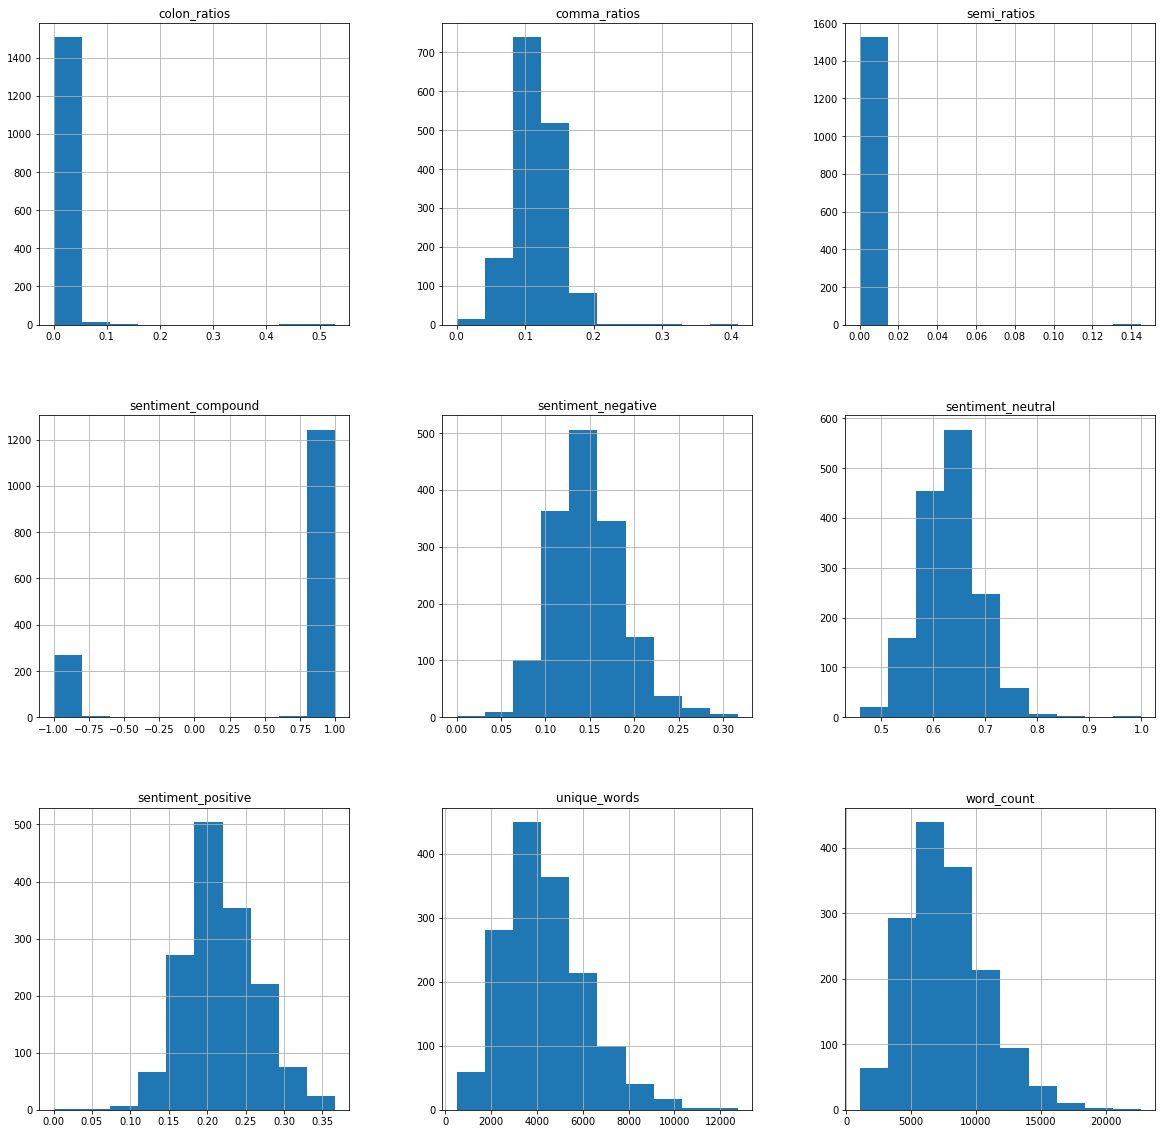

In [269]:
temp.hist(figsize=(20,20));

In [270]:
temp = rotten_df_cut[rotten_df_cut.columns[24:41]].copy()
temp['RottenScore'] = rotten_df_cut.RottenScores

dimensions = []

for column in temp.columns:
    dimensions.append({'label':column,'values':temp[column]})

# dimensions.append({'label':'RottenScores', 'values':rotten_df_cut.RottenScores})

In [271]:
data = [go.Splom(
    dimensions=dimensions,
    marker={'size':2,
            'color':rotten_df_cut.RottenScores/100,
            'colorbar':{'thickness':20}
           }
)]

layout = go.Layout(height=1600,
                   width=1600)

fig = go.Figure(data, layout)
fig.show();    
# pyo.plot(fig);

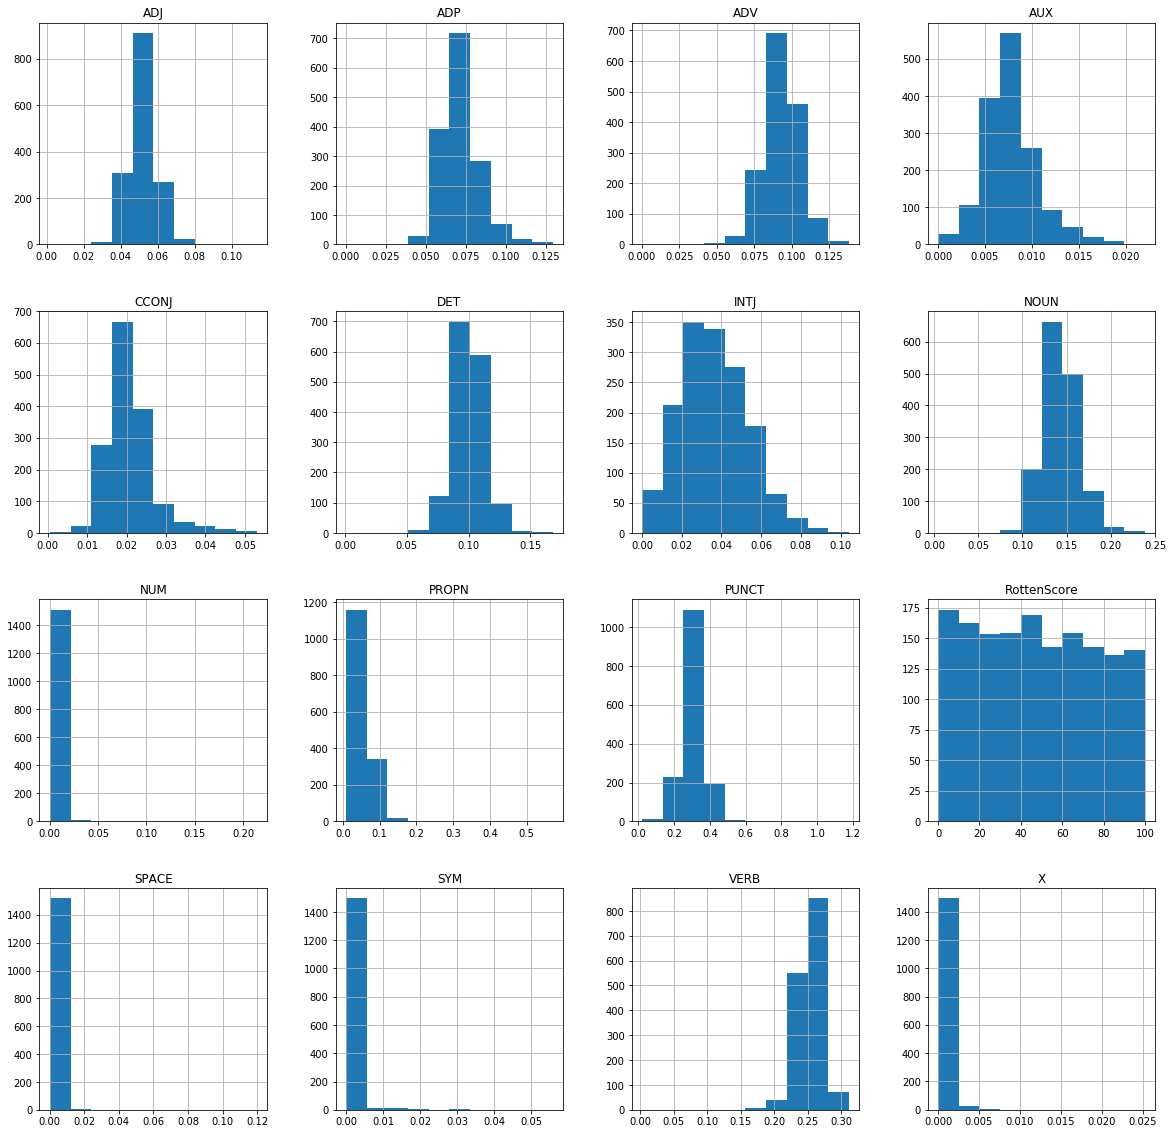

In [272]:
temp.hist(figsize=(20,20));

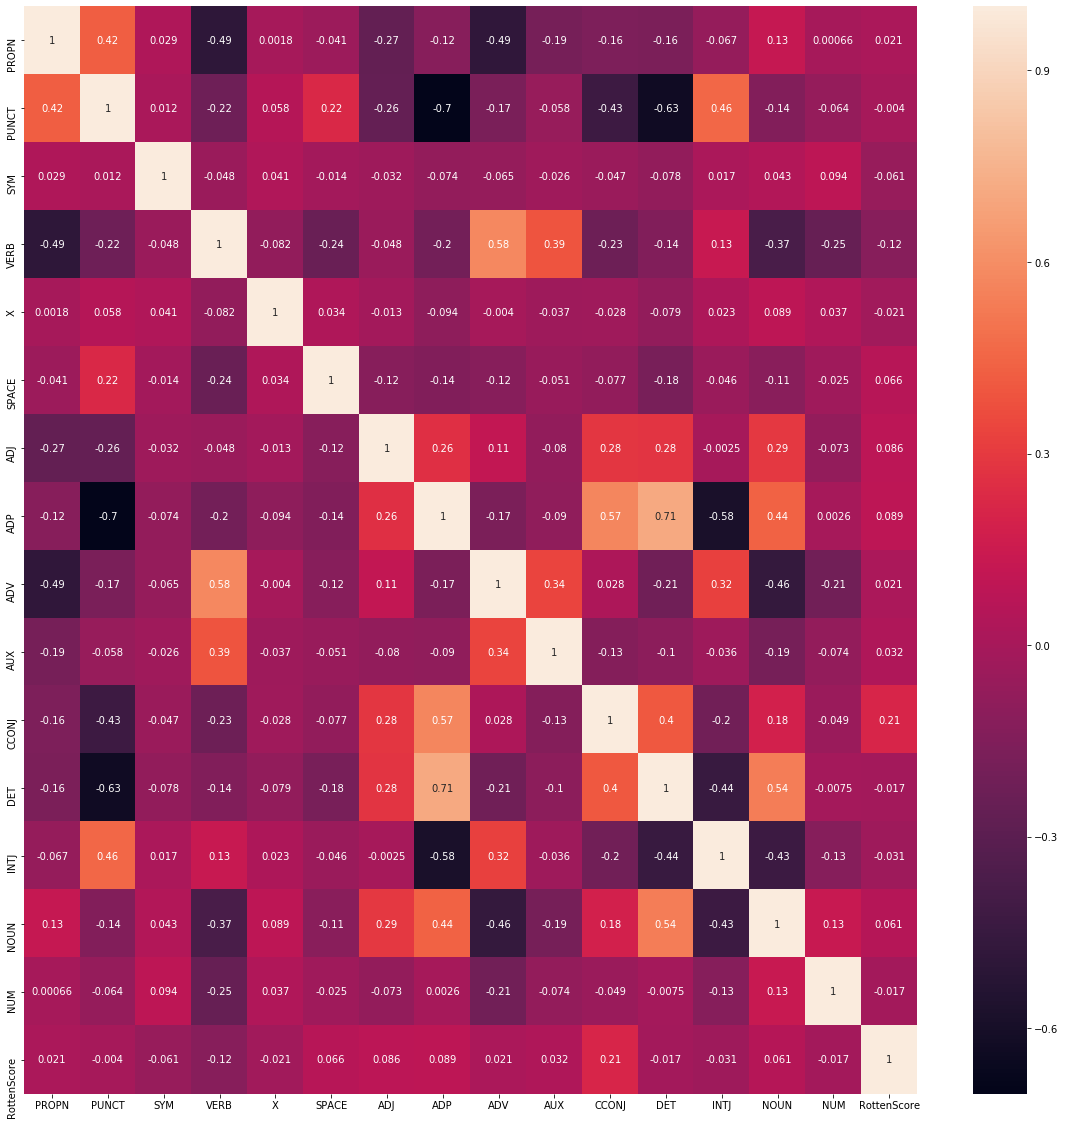

In [273]:
plt.subplots(figsize=(20,20))
sns.heatmap(temp.corr(), annot = True)

In [274]:
temp = rotten_df_cut[rotten_df_cut.columns[41:50]].copy()
temp['category'] = rotten_df_cut.category
temp['RottenScores'] = rotten_df_cut.RottenScores

dimensions = []

for column in temp.columns:
    dimensions.append({'label':column,'values':temp[column]})

# dimensions.append({'label':'category', 'values':rotten_df_cut.category})
# dimensions.append({'label':'RottenScores', 'values':rotten_df_cut.RottenScores})

In [275]:
data = [go.Splom(
    dimensions=dimensions,
    marker={'size':2,
            'color':rotten_df_cut.RottenScores/100,
#             'opacity':.5,
            'colorbar':{'thickness':20},
           }
)]

layout = go.Layout(height=1600,
                   width=1600)

fig = go.Figure(data, layout)
fig.show();    
# pyo.plot(fig);

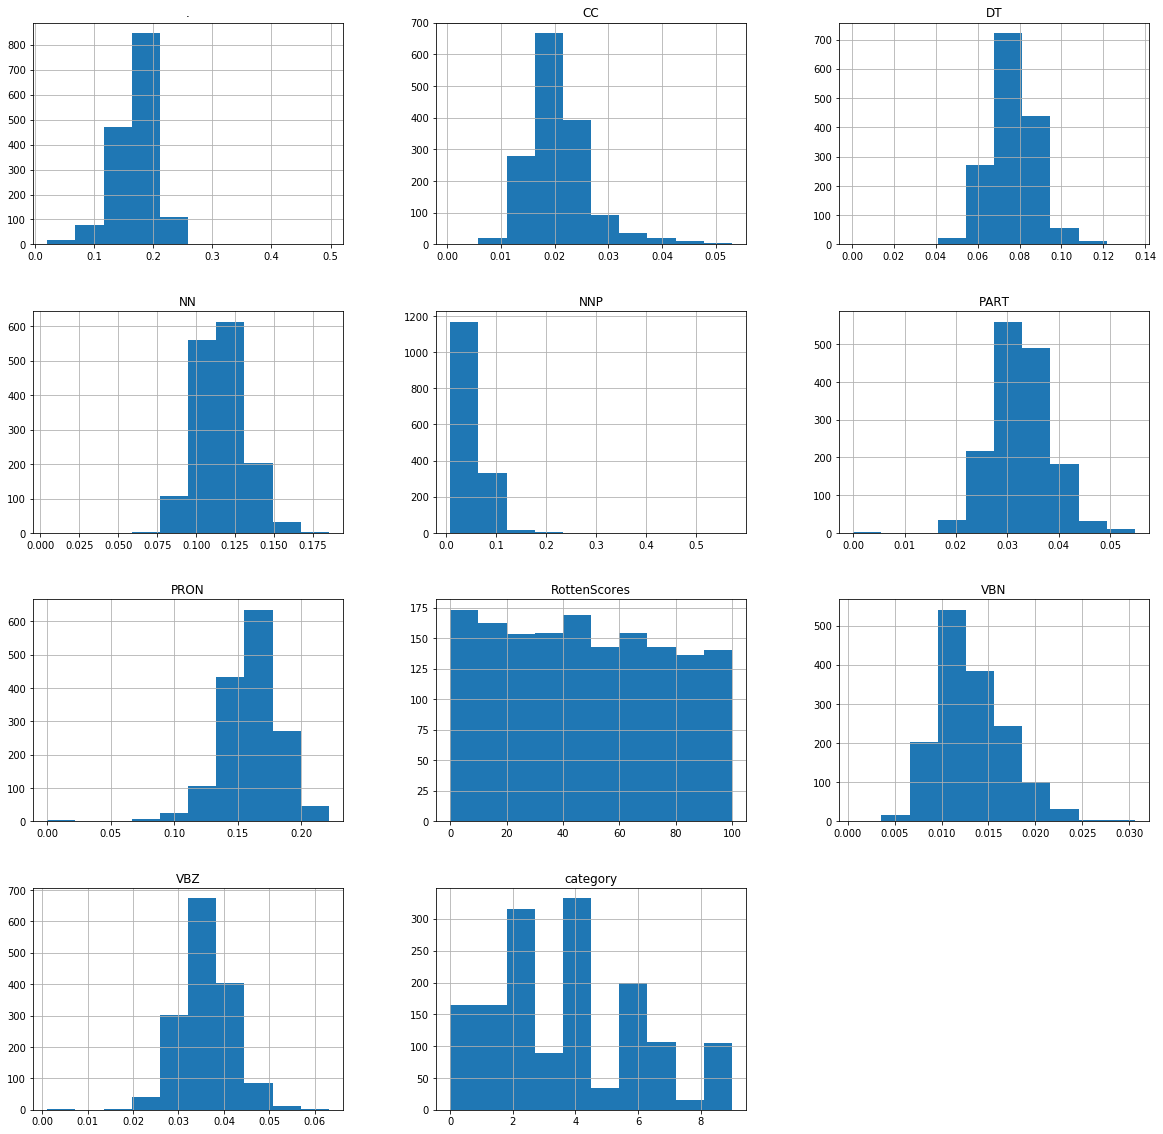

In [276]:
temp.hist(figsize=(20,20));

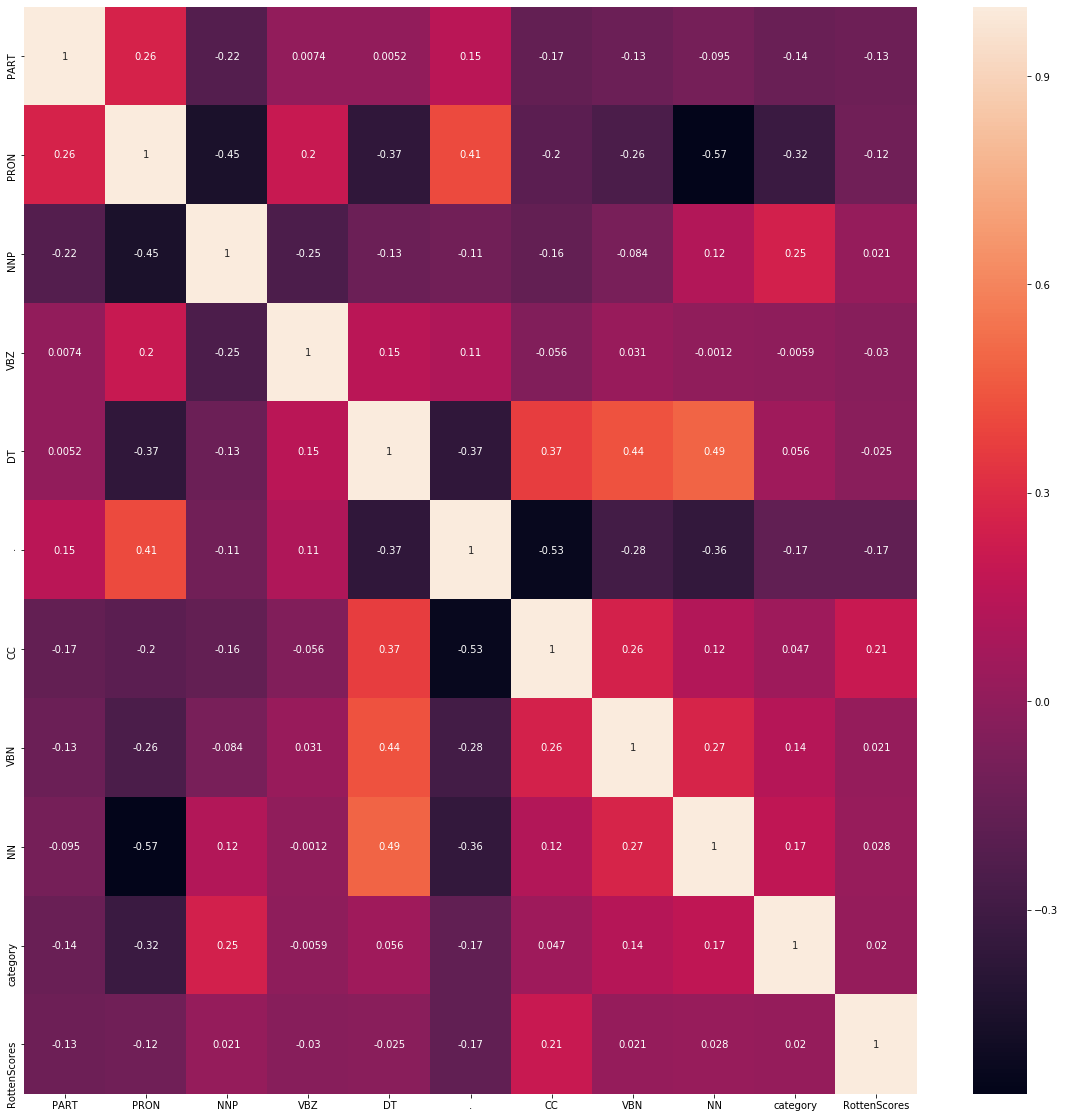

In [277]:
plt.subplots(figsize=(20,20))
sns.heatmap(temp.corr(), annot = True)

# Modeling

## Text Embedding

### Neural Network

In [278]:
X = screenplays_cut['no_stop']
y = screenplays_cut['good_or_bad']

In [279]:
X = X.loc[~X.index.duplicated(keep='first')]
y = y.loc[~y.index.duplicated(keep='first')]

In [280]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25,
                                                    random_state=42)

In [281]:
rus = RandomUnderSampler(random_state=42)
Xt_resampled, yt_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)

In [282]:
Xt_resampled = Xt_resampled['no_stop']

In [283]:
X_shuffled = shuffle(Xt_resampled, random_state=42)
y_shuffled = shuffle(yt_resampled, random_state=42)

In [284]:
tokenizer = text.Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_shuffled)
list_tokenized_scripts = tokenizer.texts_to_sequences(X_shuffled)
# X_t_train = list_tokenized_scripts
X_t_train = sequence.pad_sequences(list_tokenized_scripts, maxlen=5000)

In [285]:
# X_tf_train = tf.variable(X_t_train)

In [286]:
# X_t_train = np.array([np.array(item) for item in list_tokenized_scripts])

In [287]:
# y_t_train = pd.get_dummies(yt_resampled)
# X_t_train = np.array(Xt_resampled)
# y_t_train = yt_resampled
y_t_train = y_shuffled

In [288]:
model = Sequential()

embedding_size = 128
model.add(Embedding(5000, embedding_size))
model.add(LSTM(128, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [289]:
model.compile(loss='mean_squared_error',
              optimizer='adam', 
              metrics=['accuracy'])

In [290]:
# model.summary()

In [291]:
model.fit(X_t_train, y_t_train, epochs=10, batch_size=50, validation_split=0.1)

//anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 1675 samples, validate on 187 samples
Epoch 1/10
1675/1675 [==============================] - 220s 132ms/step - loss: 0.2489 - accuracy: 0.5433 - val_loss: 0.2446 - val_accuracy: 0.6578
Epoch 2/10
1675/1675 [==============================] - 174s 104ms/step - loss: 0.2256 - accuracy: 0.6866 - val_loss: 0.2040 - val_accuracy: 0.6898
Epoch 3/10
1675/1675 [==============================] - 168s 100ms/step - loss: 0.1960 - accuracy: 0.7349 - val_loss: 0.2099 - val_accuracy: 0.6845
Epoch 4/10
1675/1675 [==============================] - 163s 98ms/step - loss: 0.2074 - accuracy: 0.7176 - val_loss: 0.2098 - val_accuracy: 0.6524
Epoch 5/10
1675/1675 [==============================] - 163s 97ms/step - loss: 0.1217 - accuracy: 0.8448 - val_loss: 0.2279 - val_accuracy: 0.6364
Epoch 6/10
1675/1675 [==============================] - 162s 97ms/step - loss: 0.0692 - accuracy: 0.9296 - val_loss: 0.2198 - val_accuracy: 0.6845
Epoch 7/10
1675/1675 [==============================] - 163s 97ms/st

In [292]:
# X_t_test = X_test

In [293]:
tokenizer = text.Tokenizer(num_words=5000)
tokenizer.fit_on_texts(list(X_test))
list_tokenized_scripts = tokenizer.texts_to_sequences(X_test)
X_t_test = sequence.pad_sequences(list_tokenized_scripts, maxlen=5000)

In [294]:
# y_t_test = pd.get_dummies(y_test)
y_t_test = y_test

In [295]:
model.metrics_names

['loss', 'accuracy']

In [296]:
model.evaluate(X_t_test, y_t_test, verbose=1)

691/691 [==============================] - 18s 26ms/step


[0.348528011145364, 0.5137481689453125]

              precision    recall  f1-score   support

           0       0.56      0.39      0.46       368
           1       0.49      0.65      0.56       323

    accuracy                           0.51       691
   macro avg       0.52      0.52      0.51       691
weighted avg       0.53      0.51      0.51       691



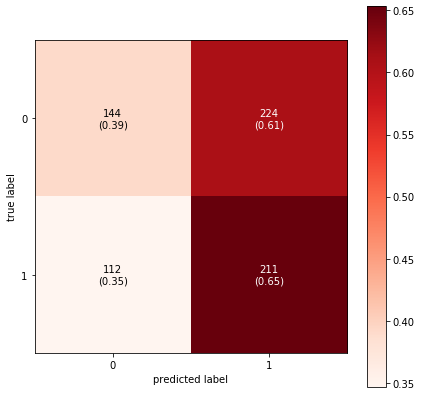

In [297]:
y_pred = model.predict_classes(X_t_test)

print(classification_report(y_t_test, y_pred))

confusion = confusion_matrix(y_t_test, y_pred)
plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                  show_normed=True, cmap=plt.cm.Reds);
plt.show();

### Script Attributes

In [298]:
X = screenplays_cut['no_stop']
y = screenplays_cut['good_or_bad']

In [299]:
dummy_cats = pd.get_dummies(screenplays_cut['category'])

In [300]:
# columns = ['colon_ratios', 'semi_ratios', 'comma_ratios', 'ellipsis_ratios']
columns = []
for column in screenplays_cut.columns[23:38]:
    columns.append(column)
    
for column in screenplays_cut.columns[39:56]:
    columns.append(column)
    
X = screenplays_cut[columns]

y = screenplays_cut.good_or_bad

In [301]:
# X = dummy_cats

In [302]:
X = X.loc[~X.index.duplicated(keep='first')]
y = y.loc[~y.index.duplicated(keep='first')]

In [303]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,
                                                    random_state=42)

In [304]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [305]:
X_train = pd.DataFrame(X_train)

In [306]:
rus = RandomUnderSampler(random_state=42)
Xt_resampled, yt_resampled = rus.fit_resample(X_train, y_train)

In [307]:
# y_t_train = pd.get_dummies(yt_resampled)
X_t_train = np.array(Xt_resampled)
y_t_train = np.array(yt_resampled)

In [308]:
model = Sequential()

# embedding_size = 128
# model.add(Embedding(20000, embedding_size))
# model.add(LSTM(128, return_sequences=True))
# model.add(GlobalMaxPool1D())
model.add(Dense(64, input_dim=32, activation='relu'))
model.add(Dense(32, input_dim=64, activation='relu'))
model.add(Dense(16, input_dim=32, activation='relu'))
# model.add(Dense(30, activation='relu'))
# model.add(Dense(30, activation='relu'))
# model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='sigmoid'))



# model.add(Dense(8, input_dim=4, activation='relu'))
# model.add(Dense(8, input_dim=4, activation='relu'))

# embedding_size = 128
# model.add(Embedding(20000, embedding_size))
# model.add(LSTM(25, return_sequences=True))
# model.add(GlobalMaxPool1D())
# model.add(Dropout(0.5))
# model.add(Dense(50, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

In [309]:
model.compile(loss='mean_squared_error',
              optimizer='adam', 
              metrics=['accuracy'])

In [310]:
# model.summary()

In [311]:
model.fit(X_t_train, y_t_train, epochs=8, batch_size=50, validation_split=0.1)

Train on 1584 samples, validate on 176 samples
Epoch 1/8
1584/1584 [==============================] - 0s 113us/step - loss: 0.2509 - accuracy: 0.5833 - val_loss: 0.2669 - val_accuracy: 0.4716
Epoch 2/8
1584/1584 [==============================] - 0s 23us/step - loss: 0.2173 - accuracy: 0.6717 - val_loss: 0.2769 - val_accuracy: 0.4830
Epoch 3/8
1584/1584 [==============================] - 0s 23us/step - loss: 0.2064 - accuracy: 0.6869 - val_loss: 0.2548 - val_accuracy: 0.5568
Epoch 4/8
1584/1584 [==============================] - 0s 21us/step - loss: 0.1992 - accuracy: 0.7008 - val_loss: 0.2576 - val_accuracy: 0.5455
Epoch 5/8
1584/1584 [==============================] - 0s 22us/step - loss: 0.1946 - accuracy: 0.7172 - val_loss: 0.2530 - val_accuracy: 0.5511
Epoch 6/8
1584/1584 [==============================] - 0s 21us/step - loss: 0.1880 - accuracy: 0.7260 - val_loss: 0.2582 - val_accuracy: 0.5568
Epoch 7/8
1584/1584 [==============================] - 0s 21us/step - loss: 0.1837 - acc

In [312]:
X_t_test = X_test

In [313]:
# y_t_test = pd.get_dummies(y_test)
y_t_test = y_test

In [314]:
model.metrics_names

['loss', 'accuracy']

In [315]:
model.evaluate(X_t_test, y_t_test, verbose=1)

829/829 [==============================] - 0s 14us/step


[0.19959650034999388, 0.6984318494796753]

              precision    recall  f1-score   support

           0       0.70      0.80      0.74       455
           1       0.70      0.57      0.63       374

    accuracy                           0.70       829
   macro avg       0.70      0.69      0.69       829
weighted avg       0.70      0.70      0.69       829



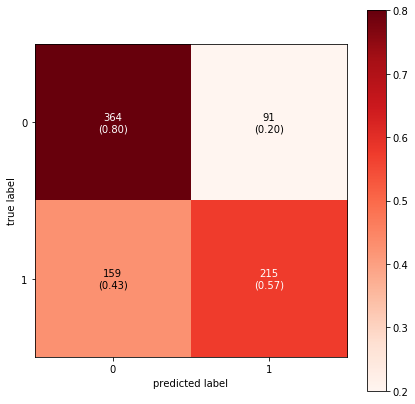

In [316]:
y_pred = model.predict_classes(X_t_test)

print(classification_report(y_test, y_pred))

confusion = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                  show_normed=True, cmap=plt.cm.Reds);
plt.show();

### TFIDF Vectorization with Script Attributes

In [317]:
X_test = pd.DataFrame(X_test)

In [318]:
dummy_cats = pd.get_dummies(screenplays_cut['category'])

In [321]:
# columns = ['colon_ratios', 'semi_ratios', 'comma_ratios', 'ellipsis_ratios']
columns = []
for column in screenplays_cut.columns[23:38]:
    columns.append(column)
    
for column in screenplays_cut.columns[39:56]:
    columns.append(column)
    
X = screenplays_cut[columns]

X = pd.merge(screenplays_cut[columns], dummy_cats, left_index=True, right_index=True)
y = screenplays_cut.good_or_bad

In [322]:
X2 = screenplays_cut['no_stop']
# y = screenplays_cut['good_or_bad']

In [323]:
X = X.loc[~X.index.duplicated(keep='first')]
X2 = X2.loc[~X.index.duplicated(keep='first')]
y = y.loc[~y.index.duplicated(keep='first')]

In [324]:
tfidf = TfidfVectorizer(max_features=5000, max_df=.95, min_df=.1, 
                        ngram_range=(1,2))
X2 = tfidf.fit_transform(X2)

In [325]:
X_sdf = pd.SparseDataFrame(X2, columns=tfidf.get_feature_names(),
                           default_fill_value=0)

X = X.reset_index(drop=True)

for column in X:
    X_sdf[column] = X[column]

In [326]:
X_train, X_test, y_train, y_test = train_test_split(X_sdf, y, test_size=.3,
                                                    random_state=42)

In [327]:
X_train = pd.DataFrame(X_train)

In [328]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)

In [329]:
if type(X_resampled) == pd.core.series.Series:
    X_resampled = X_resampled.iloc[:, 0]

In [330]:
# X_train = pd.SparseDataFrame(X_train, columns=tfidf.get_feature_names(),
#                            default_fill_value=0)

In [331]:
X_shuffled = shuffle(X_resampled, random_state=42)
y_shuffled = shuffle(y_resampled, random_state=42)

In [334]:
# X_t_Num = np.array(X_t_train)
# y_t_Num = np.array(y_resampled)

In [342]:
model = Sequential()

model.add(Dense(4437, input_dim=4437, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
# model.add(Dense(50, activation='relu'))
# model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [345]:
model.compile(loss='mean_squared_error',
              optimizer='adam', 
              metrics=['accuracy'])

In [346]:
model.fit(X_train, y_train, epochs=15, batch_size=15, 
          validation_split=0.2)

Train on 1547 samples, validate on 387 samples
Epoch 1/15
1547/1547 [==============================] - 20s 13ms/step - loss: 0.1564 - accuracy: 0.7725 - val_loss: 0.1604 - val_accuracy: 0.7674
Epoch 2/15
1547/1547 [==============================] - 20s 13ms/step - loss: 0.0810 - accuracy: 0.8869 - val_loss: 0.1681 - val_accuracy: 0.7700
Epoch 3/15
1547/1547 [==============================] - 20s 13ms/step - loss: 0.0381 - accuracy: 0.9548 - val_loss: 0.1785 - val_accuracy: 0.7700
Epoch 4/15
1547/1547 [==============================] - 20s 13ms/step - loss: 0.0262 - accuracy: 0.9683 - val_loss: 0.1765 - val_accuracy: 0.7829
Epoch 5/15
1547/1547 [==============================] - 20s 13ms/step - loss: 0.0261 - accuracy: 0.9632 - val_loss: 0.1974 - val_accuracy: 0.7597
Epoch 6/15
1547/1547 [==============================] - 19s 12ms/step - loss: 0.0185 - accuracy: 0.9793 - val_loss: 0.1949 - val_accuracy: 0.7623
Epoch 7/15
1547/1547 [==============================] - 19s 12ms/step - loss:

In [347]:
X_test = pd.DataFrame(X_test)

In [348]:
model.evaluate(X_test, y_test, verbose=1)

829/829 [==============================] - 1s 717us/step


[0.22856108177412837, 0.7466827630996704]

              precision    recall  f1-score   support

           0       0.78      0.76      0.77       455
           1       0.71      0.73      0.72       374

    accuracy                           0.75       829
   macro avg       0.74      0.75      0.74       829
weighted avg       0.75      0.75      0.75       829



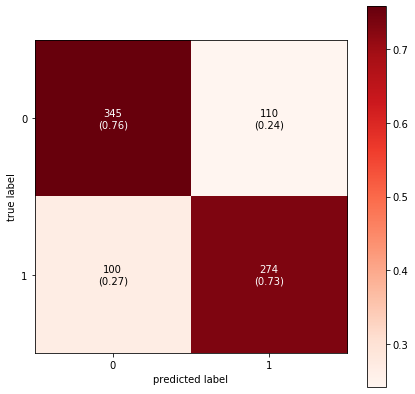

In [349]:
y_pred = model.predict_classes(X_test)

print(classification_report(y_test, y_pred))

confusion = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                  show_normed=True, cmap=plt.cm.Reds);
plt.show();

## TFID Vectorization

Screenplays DataFrame description.

    'scripts': Initial list broken out by line.
    'all_together_now': Each script made into a single string.
    'no_stop': Same as all_together_now but stop words removed.

Making sure there are no empty strings in this mess.

In [351]:
# empty = []

# for t, s, g_b, a_t_n, n_s in screenplays.itertuples():
#     if type(s) == str:
#         if s.isspace():
#             empty.append(i)
            
# print(empty)

In [352]:
X = screenplays_cut.no_stop
y = screenplays_cut.good_or_bad

### Linear Support Vector Classifier

              precision    recall  f1-score   support

           0       0.80      0.75      0.77       455
           1       0.71      0.78      0.75       374

    accuracy                           0.76       829
   macro avg       0.76      0.76      0.76       829
weighted avg       0.76      0.76      0.76       829



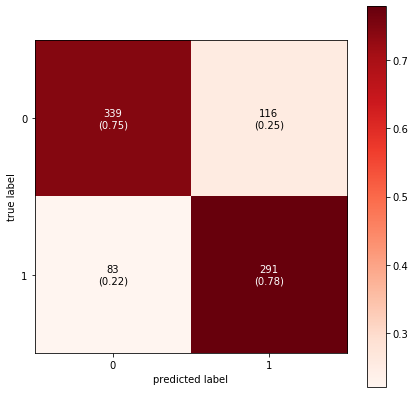

roc_auc score:  0.8358288770053477


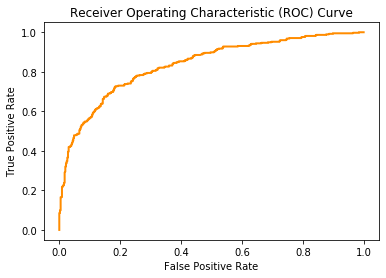

In [353]:
script_classifiers(X, y, LinearSVC(random_state=42))

### Support Vector Classifier

              precision    recall  f1-score   support

           0       0.81      0.76      0.79       455
           1       0.73      0.78      0.76       374

    accuracy                           0.77       829
   macro avg       0.77      0.77      0.77       829
weighted avg       0.77      0.77      0.77       829



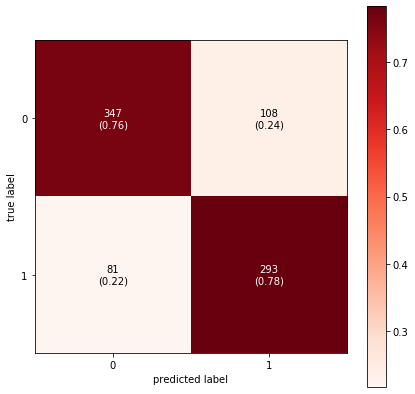

roc_auc score:  0.8386730916142681


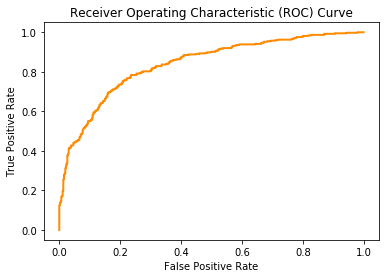

In [354]:
script_classifiers(X, y, SVC())

### Decision Tree Classifier

              precision    recall  f1-score   support

           0       0.65      0.59      0.62       455
           1       0.55      0.61      0.58       374

    accuracy                           0.60       829
   macro avg       0.60      0.60      0.60       829
weighted avg       0.60      0.60      0.60       829



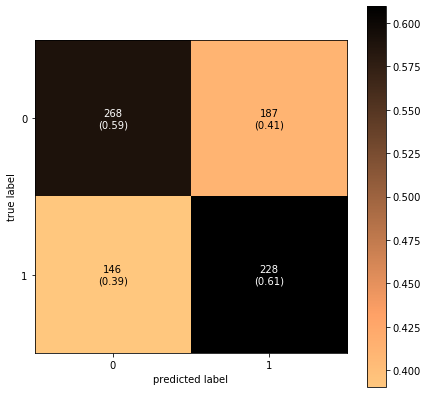

In [355]:
script_classifiers(X, y, DecisionTreeClassifier(), plt.cm.copper_r)

### Logistic Regression Classifier

              precision    recall  f1-score   support

           0       0.80      0.77      0.78       455
           1       0.73      0.76      0.74       374

    accuracy                           0.76       829
   macro avg       0.76      0.76      0.76       829
weighted avg       0.77      0.76      0.77       829



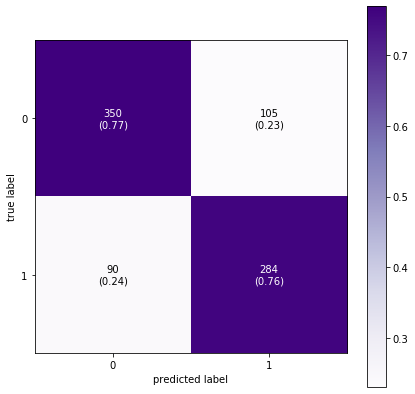

roc_auc score:  0.8328730093435975


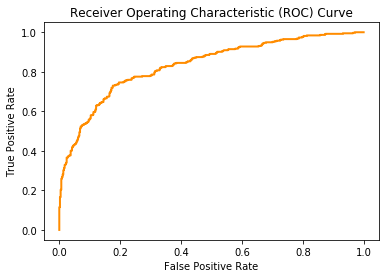

In [356]:
script_classifiers(X, y, LogisticRegression(), cmap=plt.cm.Purples)

### XG Boost Classifier

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       455
           1       0.72      0.72      0.72       374

    accuracy                           0.75       829
   macro avg       0.74      0.74      0.74       829
weighted avg       0.75      0.75      0.75       829



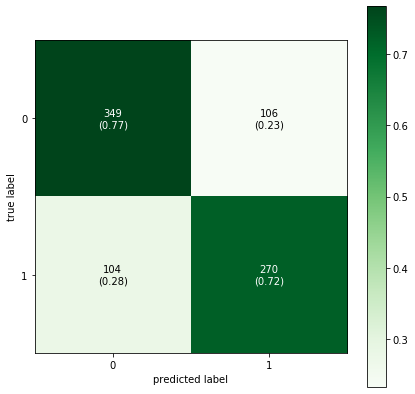

In [357]:
script_classifiers(X, y, XGBClassifier(max_depth=8,
                                        criterion='entropy',
                                        min_samples_split=14,
                                        min_samples_leaf=1,
                                        max_features=160),
                                        cmap=plt.cm.Greens)

### Random Forest Classifier

In [358]:
parameters = {
              'clf__criterion': ['entropy'],
              'clf__max_depth': [8],
              'clf__min_samples_split': [14],
              'clf__min_samples_leaf': [1],
              'clf__max_features': [160]
}
    
    
#     'criterion': ['gini', 'entropy'],
#         'max_depth': [2,3,6,7,8],
#         'min_samples_split': [2,5,10,15,20,30],
#         'min_samples_leaf': [2,5,10,15,20,30],
#         'max_features': [20,30,50,100]

In [362]:
# grid_search_a(X, y, RandomForestClassifier(), param_grid=parameters)

              precision    recall  f1-score   support

           0       0.74      0.78      0.76       455
           1       0.72      0.67      0.69       374

    accuracy                           0.73       829
   macro avg       0.73      0.73      0.73       829
weighted avg       0.73      0.73      0.73       829



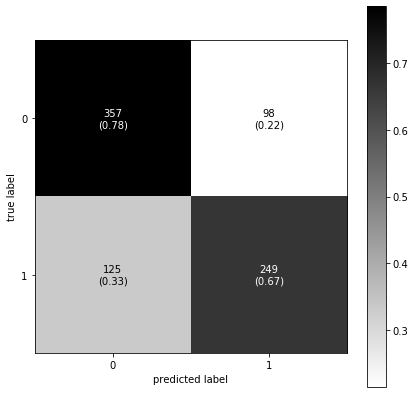

In [363]:
# parameters = {
#               'clf__criterion': ['entropy'],
#               'clf__max_depth': [8],
#               'clf__min_samples_split': [14],
#               'clf__min_samples_leaf': [1],
#               'clf__max_features': [160]

script_classifiers(X, y, RandomForestClassifier(max_depth=8,
                                                criterion='entropy',
                                                min_samples_split=14,
                                                min_samples_leaf=1,
                                                max_features=160),
                                                cmap=plt.cm.binary)

### Multinomial Bayes Classifier

              precision    recall  f1-score   support

           0       0.72      0.75      0.73       455
           1       0.67      0.64      0.66       374

    accuracy                           0.70       829
   macro avg       0.70      0.69      0.69       829
weighted avg       0.70      0.70      0.70       829



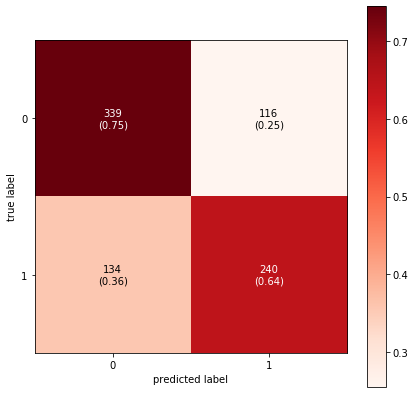

In [364]:
script_classifiers(X, y, MultinomialNB())

### Neural Network

In [1113]:
X = screenplays_cut['no_stop']
y = screenplays_cut['good_or_bad']

In [1114]:
X = X.loc[~X.index.duplicated(keep='first')]
y = y.loc[~y.index.duplicated(keep='first')]

In [1115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,
                                                    random_state=42)

In [1116]:
X_train = pd.DataFrame(X_train)

In [1117]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)

In [1118]:
X_resampled = X_resampled.iloc[:, 0]

In [1119]:
tfidf = TfidfVectorizer(max_features=5000, max_df=.95, min_df=.1, 
                        ngram_range=(1,2))
X_t_train = tfidf.fit_transform(X_resampled)
X_t_test = tfidf.transform(X_test)

In [1120]:
X_train.shape

(1934, 1)

In [1121]:
X_t_train = pd.SparseDataFrame(X_t_train, columns=tfidf.get_feature_names(),
                           default_fill_value=0)

In [1122]:
X_t_train.shape

(1760, 4389)

In [1123]:
X_t_num = np.array(X_t_train)
y_t_num = np.array(y_resampled)

In [1124]:
model = Sequential()

model.add(Dense(4389, input_dim=4389, activation='relu'))
model.add(Dense(50, input_dim=4410, activation='relu'))
# model.add(Dropout(0.7))
model.add(Dense(50, input_dim=50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [1125]:
model.compile(loss='mean_squared_error',
              optimizer='adam', 
              metrics=['accuracy'])

In [1126]:
model.fit(X_t_num, y_t_num, epochs=4, batch_size=50, validation_split=0.2)

Train on 1408 samples, validate on 352 samples
Epoch 1/4
1408/1408 [==============================] - 5s 4ms/step - loss: 0.2108 - accuracy: 0.6768 - val_loss: 0.3684 - val_accuracy: 0.4403
Epoch 2/4
1408/1408 [==============================] - 5s 3ms/step - loss: 0.1220 - accuracy: 0.8445 - val_loss: 0.3788 - val_accuracy: 0.4545
Epoch 3/4
1408/1408 [==============================] - 5s 3ms/step - loss: 0.0565 - accuracy: 0.9304 - val_loss: 0.3789 - val_accuracy: 0.4773
Epoch 4/4
1408/1408 [==============================] - 5s 3ms/step - loss: 0.0266 - accuracy: 0.9680 - val_loss: 0.1882 - val_accuracy: 0.7557


In [1127]:
# X_t_test = X_test

In [1128]:
# tokenizer = text.Tokenizer(num_words=20000)
# tokenizer.fit_on_texts(list(X_test))
# list_tokenized_scripts = tokenizer.texts_to_sequences(X_test)
# X_t_test = sequence.pad_sequences(list_tokenized_scripts, maxlen=2000)

In [1129]:
# y_t_test = pd.get_dummies(y_test)
y_t_test = y_test

In [1130]:
model.metrics_names

['loss', 'accuracy']

In [1131]:
model.evaluate(X_t_num, y_t_num, verbose=1)

1760/1760 [==============================] - 1s 323us/step


[0.04771088465455581, 0.9431818127632141]

              precision    recall  f1-score   support

           0       0.80      0.73      0.76       455
           1       0.70      0.77      0.73       374

    accuracy                           0.75       829
   macro avg       0.75      0.75      0.75       829
weighted avg       0.75      0.75      0.75       829



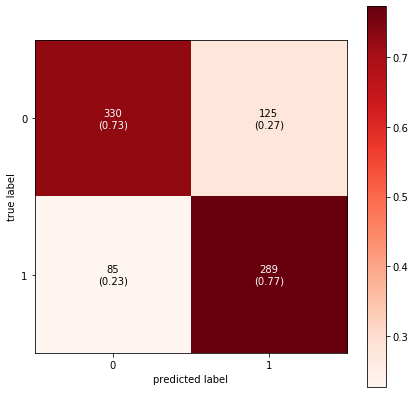

In [1132]:
y_pred = model.predict_classes(X_t_test)

print(classification_report(y_test, y_pred))

confusion = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                  show_normed=True, cmap=plt.cm.Reds);
plt.show();

## Script Attributes

In [1088]:
dummy_cats = pd.get_dummies(screenplays_cut['category'])

In [1089]:
# columns = ['category', 'unique_words', 'word_count', 'sentence_length',
#             'sentiment_positive']
columns = ['unique_words', 'word_count', 'sentence_length', 
                    'sentiment_negative', 'sentiment_neutral', 
                    'sentiment_positive', 'sentiment_compound',
                    'ellipsis_ratios', 'semi_ratios', 'colon_ratios', 
                    'comma_ratios']
for column in screenplays_cut.columns[23:38]:
    columns.append(column)
    
# X = screenplays_cut[columns]
X = pd.merge(screenplays_cut[columns], dummy_cats, left_index=True, 
             right_index=True)
# X = screenplays_cut[['unique_words', 'word_count']]
y = screenplays_cut.good_or_bad

In [1090]:
X = X.loc[~X.index.duplicated(keep='first')]
y = y.loc[~y.index.duplicated(keep='first')]

### Support Vector Classifier

              precision    recall  f1-score   support

           0       0.61      0.75      0.67       455
           1       0.57      0.41      0.48       374

    accuracy                           0.59       829
   macro avg       0.59      0.58      0.57       829
weighted avg       0.59      0.59      0.58       829



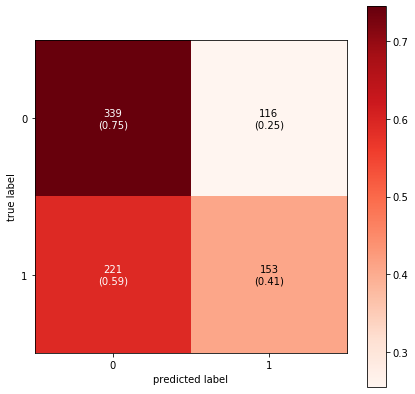

roc_auc score:  0.614985014985015


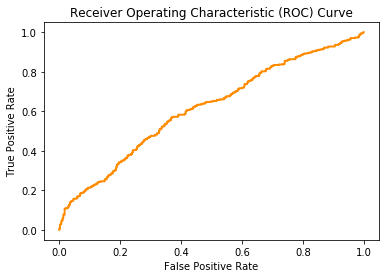

In [1078]:
script_classifiers(X, y, classifier=SVC(), use_tfidf=False)

### Decision Tree Classifier

              precision    recall  f1-score   support

           0       0.63      0.59      0.61       455
           1       0.54      0.58      0.56       374

    accuracy                           0.59       829
   macro avg       0.59      0.59      0.59       829
weighted avg       0.59      0.59      0.59       829



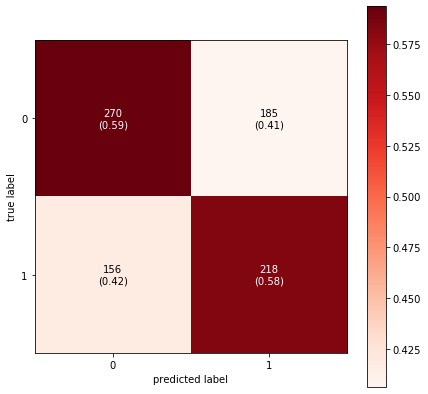

In [1079]:
script_classifiers(X, y, classifier=DecisionTreeClassifier(), use_tfidf=False)

### Logistic Regression Classifier

              precision    recall  f1-score   support

           0       0.63      0.39      0.49       455
           1       0.50      0.72      0.59       374

    accuracy                           0.54       829
   macro avg       0.57      0.56      0.54       829
weighted avg       0.57      0.54      0.53       829



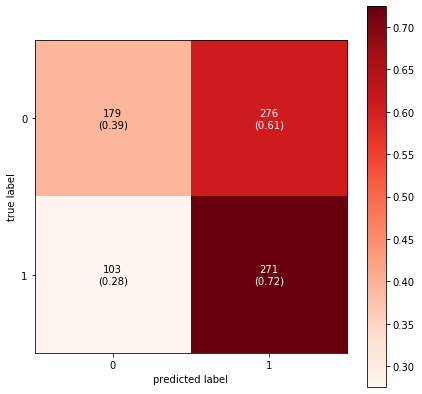

roc_auc score:  0.6034377387318564


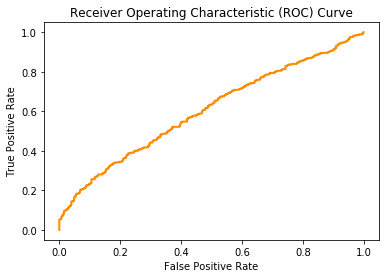

In [1080]:
script_classifiers(X, y, classifier=LogisticRegression(), use_tfidf=False)

### XG Boost Classifier

   unique_words  word_count  sentence_length  sentiment_negative  \
0          5456        9624         2.380454               0.151   
1          6179       10625         2.518956               0.163   
2          3106        5255         2.755989               0.197   
3          5751        9831         3.046081               0.191   
4          4514        8086         3.252161               0.127   

   sentiment_neutral  sentiment_positive  sentiment_compound  ellipsis_ratios  \
0              0.532               0.317              1.0000         0.052969   
1              0.603               0.234              0.9999         0.037385   
2              0.630               0.173             -0.9986         0.049581   
3              0.562               0.247              0.9999         0.009042   
4              0.584               0.289              1.0000         0.028578   

   semi_ratios  colon_ratios  comma_ratios     PROPN     PUNCT       SYM  \
0          0.0      0.001833

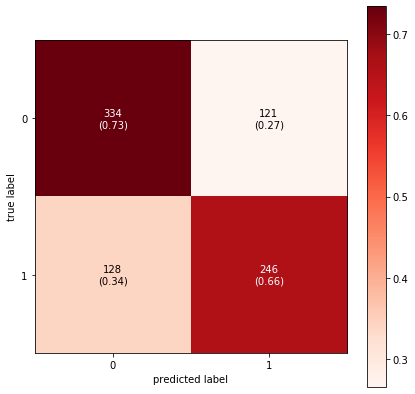

In [1093]:
script_classifiers(X, y, classifier=XGBClassifier(),use_tfidf=False)

### Random Forest Classifier

unique_words  word_count  sentence_length  sentiment_negative  \
0          6219        8401         5.270339               0.129   
1          6953       13144         3.542028               0.168   
2          4291        8092         3.116195               0.163   
3          1233        2191         2.887588               0.150   
4          7138       14231         6.396057               0.236   

   sentiment_neutral  sentiment_positive  sentiment_compound  ellipsis_ratios  \
0              0.643               0.227              0.9999         0.015597   
1              0.683               0.149             -0.9997         0.017259   
2              0.632               0.204              0.9992         0.030529   
3              0.586               0.264              0.9996         0.036496   
4              0.602               0.162             -1.0000         0.009947   

   semi_ratios  colon_ratios  comma_ratios     PROPN     PUNCT       SYM  \
0     0.000322      0.000482      0.076379  0.092965  0.436615  0.000000   
1     0.000000      0.002445      0.083273  0.007912  0.247337  0.000609   
2     0.000000      0.000233      0.127709  0.079461  0.259392  0.000000   
3     0.000000      0.004866      0.078670  0.067093  0.275217  0.000456   
4     0.000000      0.000140      0.126926  0.053123  0.150727  0.000422   

       VERB         X     SPACE       ADJ       ADP       ADV       AUX  \
0  0.179979  0.001666  0.007499  0.043923  0.044995  0.064040  0.005237   
1  0.259206  0.000000  0.000152  0.055463  0.079808  0.096318  0.008521   
2  0.237024  0.000000  0.000247  0.049061  0.090213  0.076372  0.006179   
3  0.266089  0.000000  0.000913  0.045185  0.066636  0.101780  0.009585   
4  0.210526  0.000000  0.000141  0.069004  0.127890  0.074837  0.005692   

      CCONJ       DET      INTJ      NOUN       NUM  0  1  2  3  4  5  6  7  \
0  0.012499  0.069397  0.035234  0.150815  0.006904  0  0  1  0  0  0  0  0   
1  0.014836  0.125837  0.017194  0.154976  0.018868  0  1  0  0  0  0  0  0   
2  0.023604  0.114310  0.017672  0.155091  0.008156  1  0  0  0  0  0  0  0   
3  0.020082  0.099954  0.022364  0.125057  0.015518  0  0  0  0  0  0  0  0   
4  0.033167  0.123674  0.007308  0.201040  0.011384  0  1  0  0  0  0  0  0   

   8  9  
0  0  0  
1  0  0  
2  0  0  
3  0  1  
4  0  0

   unique_words  word_count  sentence_length  sentiment_negative  \
0          5456        9624         2.380454               0.151   
1          6179       10625         2.518956               0.163   
2          3106        5255         2.755989               0.197   
3          5751        9831         3.046081               0.191   
4          4514        8086         3.252161               0.127   

   sentiment_neutral  sentiment_positive  sentiment_compound  ellipsis_ratios  \
0              0.532               0.317              1.0000         0.052969   
1              0.603               0.234              0.9999         0.037385   
2              0.630               0.173             -0.9986         0.049581   
3              0.562               0.247              0.9999         0.009042   
4              0.584               0.289              1.0000         0.028578   

   semi_ratios  colon_ratios  comma_ratios     PROPN     PUNCT       SYM  \
0          0.0      0.001833

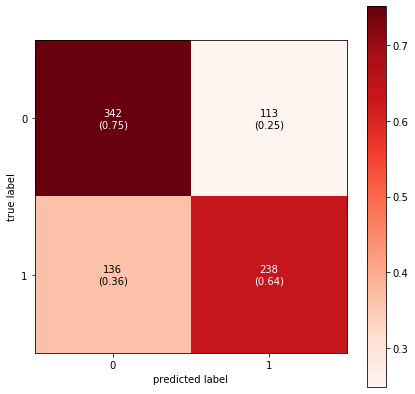

In [1094]:
script_classifiers(X, y, classifier=RandomForestClassifier(random_state=42,
                                                    max_depth=8,
                                                    criterion='entropy',
                                                    min_samples_split=14,
                                                    min_samples_leaf=1,
                                                    max_features=10),
                  use_tfidf=False)

### Neural Network

In [390]:
X = screenplays_cut['no_stop']
y = screenplays_cut['good_or_bad']

In [391]:
dummy_cats = pd.get_dummies(screenplays_cut['category'])

In [392]:
# columns = ['colon_ratios', 'semi_ratios', 'comma_ratios', 'ellipsis_ratios']
columns = []
for column in screenplays_cut.columns[23:38]:
    columns.append(column)
    
for column in screenplays_cut.columns[39:56]:
    columns.append(column)
    
X = screenplays_cut[columns]

# X = pd.merge(screenplays_cut[columns], dummy_cats, on='titles')
# X = screenplays_cut[['unique_words', 'word_count']]
y = screenplays_cut.good_or_bad

In [393]:
# X = dummy_cats

In [394]:
X = X.loc[~X.index.duplicated(keep='first')]
y = y.loc[~y.index.duplicated(keep='first')]

In [395]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,
                                                    random_state=42)

In [396]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [397]:
X_train = pd.DataFrame(X_train)
X_train.head()

0         1         2         3         4         5         6   \
0 -0.474864  0.094625 -0.164181 -0.207300 -0.126451 -0.140434 -1.212284   
1 -0.379099 -0.072139 -0.086762  0.636421 -0.208156 -0.176385  0.449684   
2  0.168072 -1.378833 -0.189824 -0.109528 -0.049387  0.016206 -0.250989   
3  0.284235  0.854977 -0.138886  0.532030 -0.137427  0.022308 -0.490204   
4  0.370260  1.150703 -0.027288 -0.702123 -0.061841 -0.158577  0.434116   

         7         8         9         10        11        12        13  \
0 -0.206293 -0.320946  1.075845 -0.156292  0.453006  0.167589 -0.324420   
1 -0.264845  0.822462 -0.536535  0.367756  0.445586  1.362735 -0.872052   
2  0.868296 -1.111652 -0.420066  0.099537  0.390286 -1.064685  0.561557   
3 -0.716494  0.385882  1.282276 -1.724549 -1.628215  0.039815 -0.821170   
4 -0.861916 -0.748629 -0.749069 -0.045798 -0.175401  1.215261 -0.185897   

         14        15        16        17        18        19        20  \
0  0.017148  0.450202  0.167589 -0.456526 -0.617050  0.301432  1.179050   
1 -0.079330  0.976438  1.362735 -0.368887  0.294439 -0.786642  0.441588   
2 -0.152076 -0.273684 -1.064685  0.168838 -0.196887 -0.248353  0.084758   
3 -0.044049  0.138617  0.039815  0.304878  0.430641  1.046103 -1.106052   
4 -0.183678 -0.279680  1.215261  0.353273  0.122475 -1.405792 -0.373990   

         21        22        23        24        25        26        27  \
0 -0.206293  0.076043 -0.156292 -0.172111 -0.148509 -1.094229  0.333812   
1 -0.264845  0.600988  0.367756 -0.636843 -0.916128  0.499283  0.944136   
2  0.868296 -0.580432  0.099537  0.985434  0.455734 -0.393676 -0.257980   
3 -0.716494  1.459257 -1.724549 -0.077126 -1.063414 -0.809746  0.090291   
4 -0.861916  0.071361 -0.045798 -1.001177 -0.013870  0.526351 -0.255965   

         28        29        30        31  
0 -0.210498  0.367854  1.044329 -0.140434  
1  0.929899 -0.310985  0.039495 -0.176385  
2 -1.244079  0.089458  0.155003  0.016206  
3  0.134042  1.253322 -0.650996  0.022308  
4 -0.495326 -0.221495 -0.722355 -0.158577

In [398]:
print(len(y_train[y_train == 0]))
print(len(y_train[y_train == 1]))

1054
880


In [399]:
rus = RandomUnderSampler(random_state=42)
Xt_resampled, yt_resampled = rus.fit_resample(X_train, y_train)

In [400]:
# y_t_train = pd.get_dummies(yt_resampled)
X_t_train = np.array(Xt_resampled)
y_t_train = np.array(yt_resampled)

In [401]:
X_t_train.shape

(1760, 32)

In [402]:
model = Sequential()

# embedding_size = 128
# model.add(Embedding(20000, embedding_size))
# model.add(LSTM(128, return_sequences=True))
# model.add(GlobalMaxPool1D())
model.add(Dense(64, input_dim=32, activation='relu'))
model.add(Dense(32, input_dim=64, activation='relu'))
model.add(Dense(16, input_dim=32, activation='relu'))
# model.add(Dense(30, activation='relu'))
# model.add(Dense(30, activation='relu'))
# model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='sigmoid'))



# model.add(Dense(8, input_dim=4, activation='relu'))
# model.add(Dense(8, input_dim=4, activation='relu'))

# embedding_size = 128
# model.add(Embedding(20000, embedding_size))
# model.add(LSTM(25, return_sequences=True))
# model.add(GlobalMaxPool1D())
# model.add(Dropout(0.5))
# model.add(Dense(50, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

In [403]:
model.compile(loss='mean_squared_error',
              optimizer='adam', 
              metrics=['accuracy'])

In [404]:
# model.summary()

In [405]:
model.fit(X_t_train, y_t_train, epochs=8, batch_size=50, validation_split=0.1)

Train on 1584 samples, validate on 176 samples
Epoch 1/8
1584/1584 [==============================] - 0s 112us/step - loss: 0.2435 - accuracy: 0.5625 - val_loss: 0.2495 - val_accuracy: 0.4886
Epoch 2/8
1584/1584 [==============================] - 0s 26us/step - loss: 0.2185 - accuracy: 0.6660 - val_loss: 0.2617 - val_accuracy: 0.5000
Epoch 3/8
1584/1584 [==============================] - 0s 24us/step - loss: 0.2076 - accuracy: 0.6812 - val_loss: 0.2525 - val_accuracy: 0.5341
Epoch 4/8
1584/1584 [==============================] - 0s 21us/step - loss: 0.2010 - accuracy: 0.7027 - val_loss: 0.2188 - val_accuracy: 0.5966
Epoch 5/8
1584/1584 [==============================] - 0s 23us/step - loss: 0.1944 - accuracy: 0.7052 - val_loss: 0.2480 - val_accuracy: 0.5398
Epoch 6/8
1584/1584 [==============================] - 0s 24us/step - loss: 0.1888 - accuracy: 0.7247 - val_loss: 0.2520 - val_accuracy: 0.5795
Epoch 7/8
1584/1584 [==============================] - 0s 22us/step - loss: 0.1837 - acc

In [406]:
X_t_test = X_test

In [407]:
# y_t_test = pd.get_dummies(y_test)
y_t_test = y_test

In [408]:
model.metrics_names

['loss', 'accuracy']

In [409]:
model.evaluate(X_t_test, y_t_test, verbose=1)

829/829 [==============================] - 0s 14us/step


[0.19794198505769162, 0.700844407081604]

              precision    recall  f1-score   support

           0       0.69      0.81      0.75       455
           1       0.71      0.57      0.63       374

    accuracy                           0.70       829
   macro avg       0.70      0.69      0.69       829
weighted avg       0.70      0.70      0.70       829



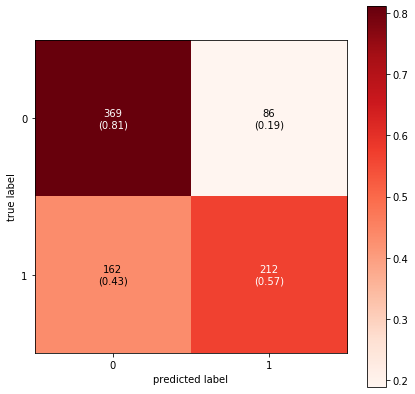

In [410]:
y_pred = model.predict_classes(X_t_test)

print(classification_report(y_test, y_pred))

confusion = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                  show_normed=True, cmap=plt.cm.Reds);
plt.show();

## TFIDF with Script Atteributes

### Setup

In [411]:
dummy_cats = pd.get_dummies(screenplays_cut['category'])

In [412]:
# POS_only = []
# for column in screenplays_cut.columns[21:38]:
#     POS_only.append(column)

# X = screenplays_cut['word_cout']
# X2 = screenplays_cut.no_stop
# y = screenplays_cut.good_or_bad

In [413]:
X = dummy_cats
X2 = screenplays_cut.no_stop
y = screenplays_cut.good_or_bad

In [414]:
X = X.loc[~X.index.duplicated(keep='first')]
y = y.loc[~y.index.duplicated(keep='first')]
X2 = X2.iloc[~X2.index.duplicated(keep='first')]

### Linear Support Vector Classifier

**This is my top model of all.**

              precision    recall  f1-score   support

           0       0.79      0.75      0.77       455
           1       0.71      0.76      0.74       374

    accuracy                           0.75       829
   macro avg       0.75      0.75      0.75       829
weighted avg       0.76      0.75      0.75       829

Accuracy:  0.7539203860072377


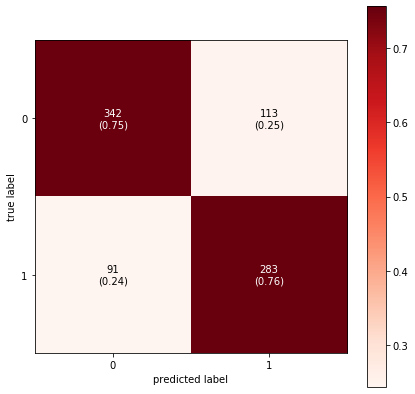

roc_auc score:  0.8333607568901685


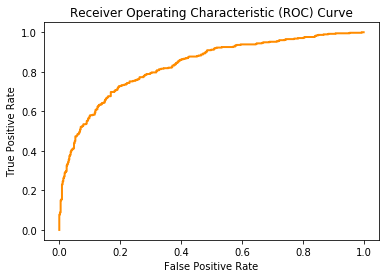

In [415]:
ceci_nest_pas_une_pipe(X, y, X2, LinearSVC(C=.6))

### Support Vector Classifier

              precision    recall  f1-score   support

           0       0.65      0.75      0.69       455
           1       0.62      0.50      0.55       374

    accuracy                           0.64       829
   macro avg       0.63      0.62      0.62       829
weighted avg       0.63      0.64      0.63       829

Accuracy:  0.6369119420989143


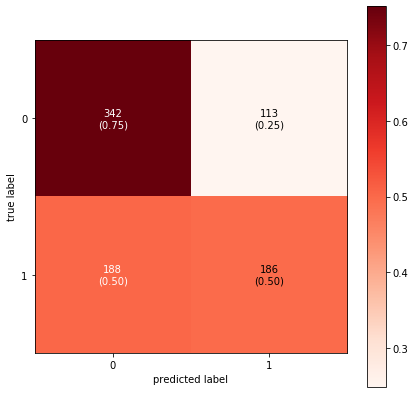

roc_auc score:  0.7337662337662336


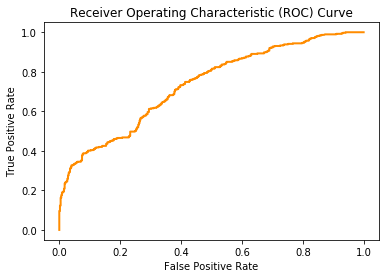

In [416]:
ceci_nest_pas_une_pipe(X, y, X2, SVC(C=.1))

### Decision Tree Classifier

              precision    recall  f1-score   support

           0       0.66      0.61      0.63       455
           1       0.56      0.61      0.59       374

    accuracy                           0.61       829
   macro avg       0.61      0.61      0.61       829
weighted avg       0.62      0.61      0.61       829

Accuracy:  0.6115802171290712


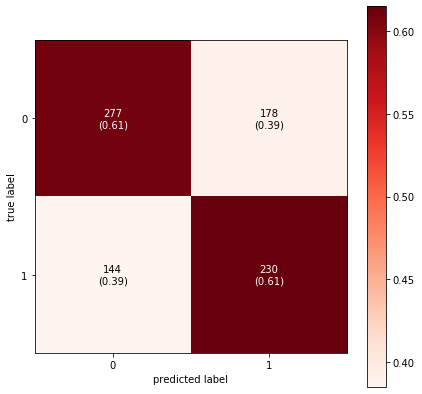

hey            0.098988
god            0.034047
kill           0.021882
plan           0.019419
though         0.015365
leave it       0.015229
admit          0.015124
guys           0.014972
breathe        0.014939
says           0.013086
what name      0.012721
don mean       0.011956
doors          0.011790
world          0.010931
that think     0.010624
19             0.010535
police         0.010525
catch          0.010403
customers      0.010315
that good      0.010204
love you       0.010179
men            0.010105
sleep          0.009799
want me        0.009501
enough         0.009408
middle         0.008754
rock           0.008729
record         0.008483
shoot          0.008167
on know        0.008145
fuck it        0.008117
sister         0.008066
living         0.008035
know mean      0.008023
forever        0.008009
out come       0.007925
why            0.007814
anyone         0.007758
partner        0.007745
interesting    0.007615
yelling        0.007592
nervous        0

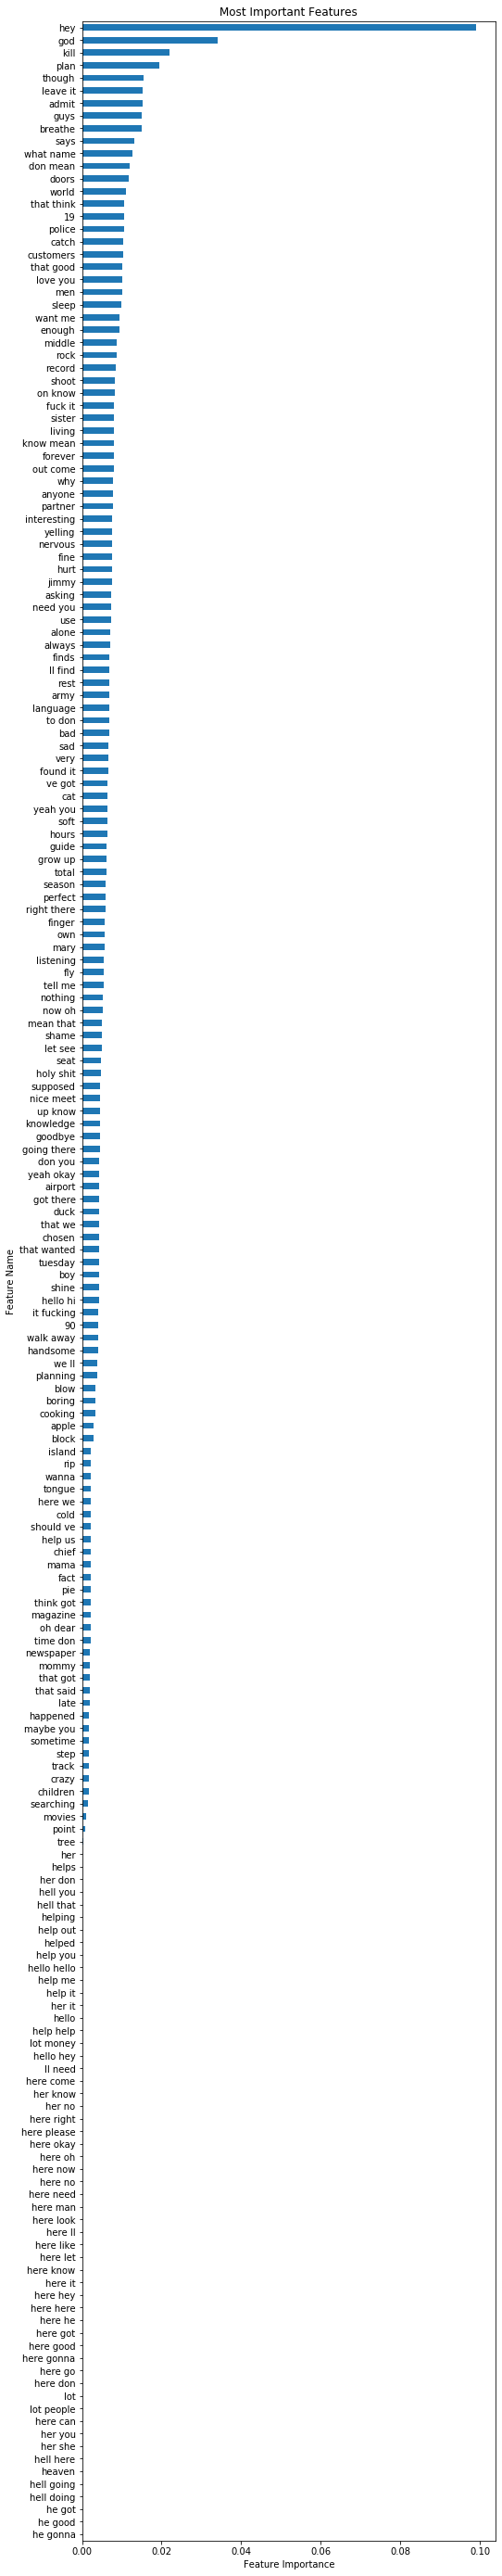

In [417]:
ceci_nest_pas_une_pipe(X, y, X2, DecisionTreeClassifier())

### Logistic Regression Classifier

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



              precision    recall  f1-score   support

           0       0.80      0.75      0.77       455
           1       0.71      0.77      0.74       374

    accuracy                           0.76       829
   macro avg       0.75      0.76      0.75       829
weighted avg       0.76      0.76      0.76       829

Accuracy:  0.7551266586248492


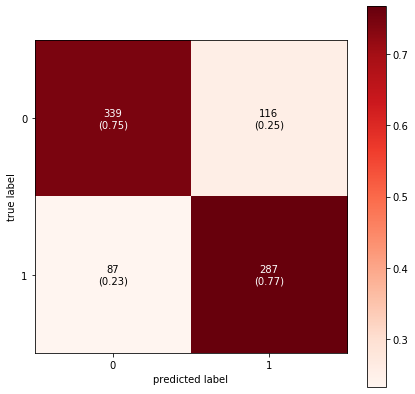

roc_auc score:  0.8321972145501557


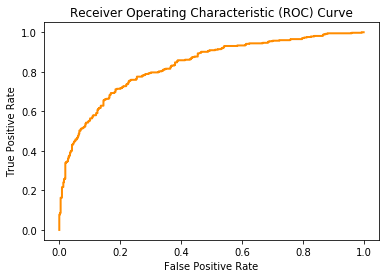

In [418]:
ceci_nest_pas_une_pipe(X, y, X2, LogisticRegression(C=10))

### XG Boost Classifier

In [419]:
# ceci_nest_pas_une_pipe(X, y, X2, XGBClassifier())
# XG Boost did not like the sparse dataframe for some reason. Skipping.

### Random Forest Classifier

              precision    recall  f1-score   support

           0       0.73      0.77      0.75       455
           1       0.70      0.65      0.67       374

    accuracy                           0.71       829
   macro avg       0.71      0.71      0.71       829
weighted avg       0.71      0.71      0.71       829

Accuracy:  0.7141133896260555


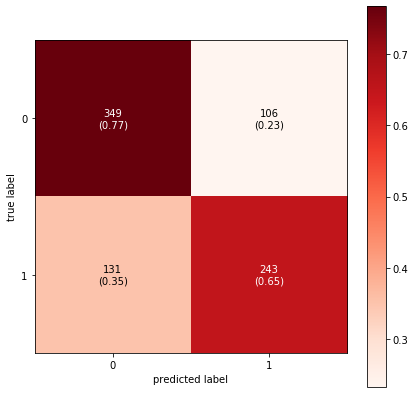

hey              0.006611
god              0.006059
okay             0.004279
let go           0.004277
hey hey          0.004075
go go            0.004074
yeah             0.004044
whoa             0.003838
guys             0.003775
oh god           0.003755
come on          0.003307
damn             0.003132
wow              0.002926
hell             0.002841
check out        0.002814
love you         0.002523
gonna            0.002376
believe          0.002374
trust me         0.002365
ass              0.002305
3                0.002267
suppose          0.002155
dude             0.002004
bitch            0.001972
plan             0.001969
guy              0.001960
wait wait        0.001926
wait             0.001899
kill             0.001844
it time          0.001809
yeah well        0.001783
know what        0.001717
sweetie          0.001709
buddy            0.001671
bit              0.001666
sitting          0.001647
no no            0.001628
trust            0.001610
gotta go    

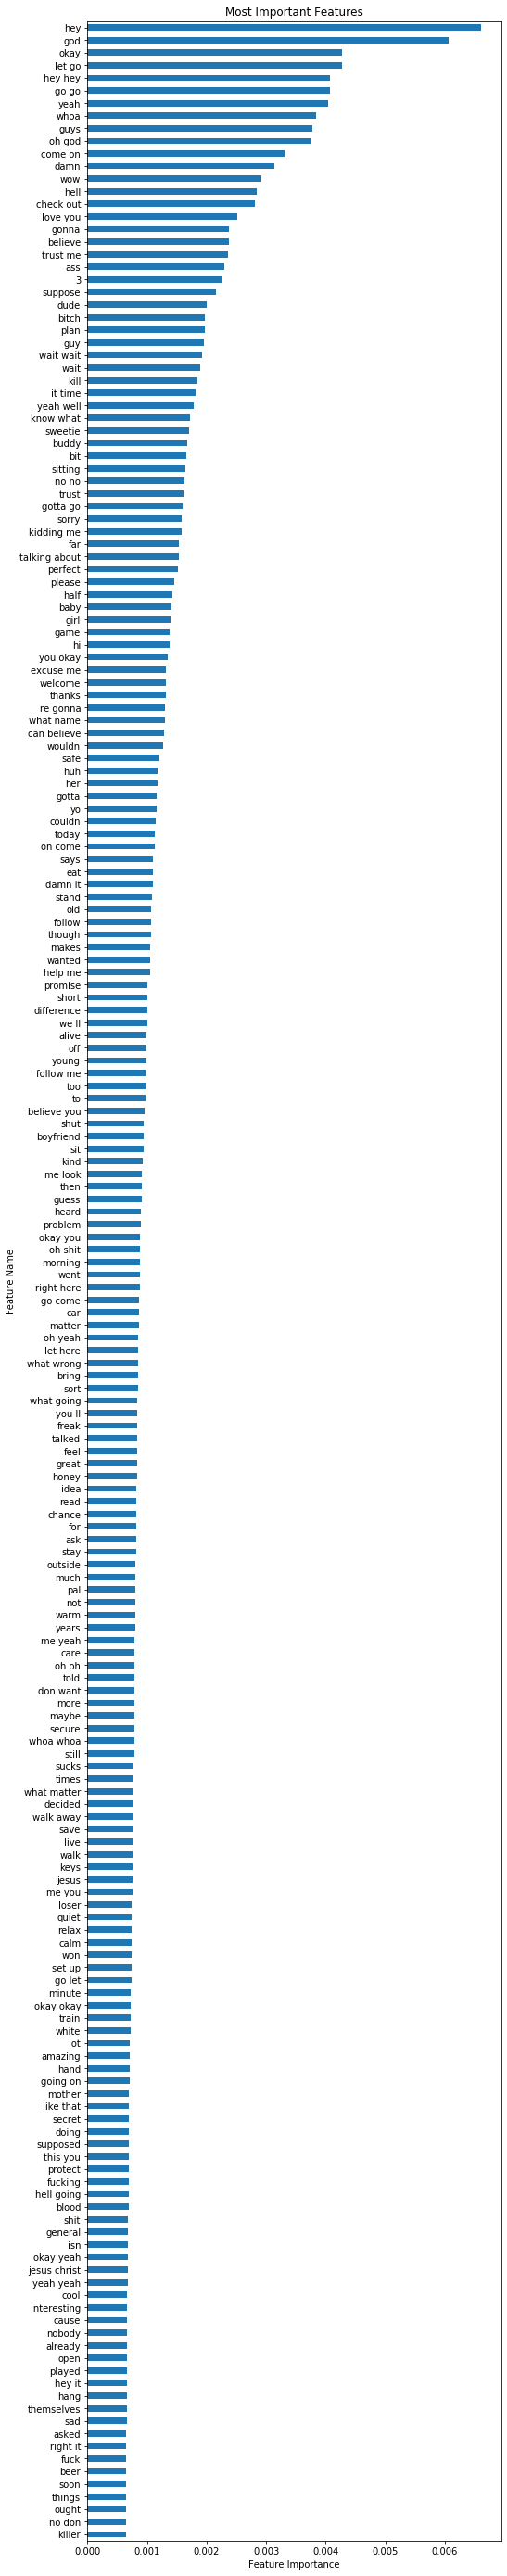

In [420]:
ceci_nest_pas_une_pipe(X, y, X2, RandomForestClassifier(random_state=42, 
                                                       n_jobs=-1),
                      importance_metrics=False)

### Neural Network

In [421]:
X = screenplays_cut['no_stop']
y = screenplays_cut['good_or_bad']

In [422]:
dummy_cats = pd.get_dummies(screenplays_cut['category'])

In [425]:
# columns = ['colon_ratios', 'semi_ratios', 'comma_ratios', 'ellipsis_ratios']
columns = []
for column in screenplays_cut.columns[23:38]:
    columns.append(column)
    
for column in screenplays_cut.columns[39:56]:
    columns.append(column)
    
X = screenplays_cut[columns]

X = pd.merge(screenplays_cut[columns], dummy_cats, left_index=True, right_index=True)
y = screenplays_cut.good_or_bad

In [426]:
X2 = screenplays_cut['no_stop']
# y = screenplays_cut['good_or_bad']

In [427]:
X = X.loc[~X.index.duplicated(keep='first')]
X2 = X2.loc[~X.index.duplicated(keep='first')]
y = y.loc[~y.index.duplicated(keep='first')]

In [428]:
tfidf = TfidfVectorizer(max_features=5000, max_df=.95, min_df=.1, 
                        ngram_range=(1,2))
X2 = tfidf.fit_transform(X2)

In [429]:
X_sdf = pd.SparseDataFrame(X2, columns=tfidf.get_feature_names(),
                           default_fill_value=0)

X = X.reset_index(drop=True)

for column in X:
    X_sdf[column] = X[column]

In [430]:
X_train, X_test, y_train, y_test = train_test_split(X_sdf, y, test_size=.3,
                                                    random_state=42)

In [431]:
X_train = pd.DataFrame(X_train)

In [432]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)

In [433]:
if type(X_resampled) == pd.core.series.Series:
    X_resampled = X_resampled.iloc[:, 0]

In [434]:
# X_train = pd.SparseDataFrame(X_train, columns=tfidf.get_feature_names(),
#                            default_fill_value=0)

In [435]:
X_shuffled = shuffle(X_resampled, random_state=42)
y_shuffled = shuffle(y_resampled, random_state=42)

In [440]:
# X_t_Num = np.array(X_t_train)
# y_t_Num = np.array(y_resampled)

In [441]:
model = Sequential()

model.add(Dense(4437, input_dim=4437, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
# model.add(Dense(50, activation='relu'))
# model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [442]:
model.compile(loss='mean_squared_error',
              optimizer='adam', 
              metrics=['accuracy'])

In [443]:
model.fit(X_shuffled, y_shuffled, epochs=8, batch_size=75, 
          validation_split=0.2)

Train on 1408 samples, validate on 352 samples
Epoch 1/8
1408/1408 [==============================] - 5s 4ms/step - loss: 0.2168 - accuracy: 0.6506 - val_loss: 0.2003 - val_accuracy: 0.7045
Epoch 2/8
1408/1408 [==============================] - 4s 3ms/step - loss: 0.1302 - accuracy: 0.8246 - val_loss: 0.1591 - val_accuracy: 0.7756
Epoch 3/8
1408/1408 [==============================] - 4s 3ms/step - loss: 0.0656 - accuracy: 0.9162 - val_loss: 0.1397 - val_accuracy: 0.8153
Epoch 4/8
1408/1408 [==============================] - 5s 3ms/step - loss: 0.0231 - accuracy: 0.9787 - val_loss: 0.1539 - val_accuracy: 0.8097
Epoch 5/8
1408/1408 [==============================] - 5s 4ms/step - loss: 0.0116 - accuracy: 0.9893 - val_loss: 0.1556 - val_accuracy: 0.7955
Epoch 6/8
1408/1408 [==============================] - 5s 3ms/step - loss: 0.0076 - accuracy: 0.9929 - val_loss: 0.1600 - val_accuracy: 0.8182
Epoch 7/8
1408/1408 [==============================] - 5s 3ms/step - loss: 0.0064 - accuracy: 0

In [444]:
X_test_shuffled = shuffle(X_test, random_state=42)
y_test_shuffled = shuffle(y_test, random_state=42)

In [445]:
X_test = pd.DataFrame(X_test)

In [446]:
model.evaluate(X_test, y_test, verbose=1)

829/829 [==============================] - 1s 652us/step


[0.1981548855690099, 0.7515078186988831]

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       455
           1       0.72      0.73      0.73       374

    accuracy                           0.75       829
   macro avg       0.75      0.75      0.75       829
weighted avg       0.75      0.75      0.75       829



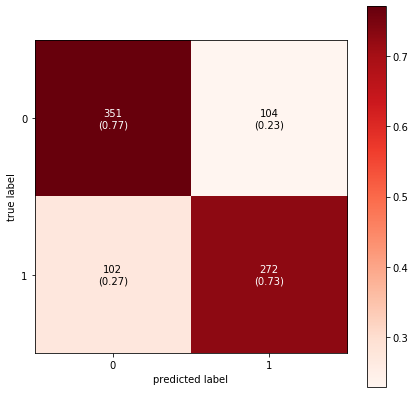

In [447]:
y_pred = model.predict_classes(X_test)

print(classification_report(y_test, y_pred))

confusion = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                  show_normed=True, cmap=plt.cm.Reds);
plt.show();

## Linear Regression with Rottentomatoes

### Features Only with Statsmodels OLS

In [536]:
rotten_df_cut.rename(columns={'.':'PER'}, inplace=True)

In [538]:
to_drop = rotten_df_cut.columns[:10]
to_drop = to_drop.append(rotten_df_cut.columns[21:26])

In [539]:
rotten_df_cut.head(1)

Unnamed: 0  Unnamed: 0.1              Titles     TitlesFormatted  \
0           0             0  the_gallows_act_ii  gallows-act-ii-the   

   RottenScores                                            Scripts  \
0             0  ['\n\n                        1', ' - Do it.',...   

                                      AllTogetherNow  \
0  \n\n                        1 - Do it. - All r...   

                                              NoStop  \
0   1 - it. - right. oh, gosh. oh, gosh. that, br...   

                                           JustWords  \
0   1 right oh gosh oh gosh bro charlie mexican d...   

                                    sentiment_scores  sentiment_negative  \
0  {'neg': 0.172, 'neu': 0.56, 'pos': 0.269, 'com...               0.172   

   sentiment_neutral  sentiment_positive  sentiment_compound  word_count  \
0               0.56               0.269              0.9999        4896   

   unique_words  colon_ratios  semi_ratios  comma_ratios  ellipsis_ratios  \
0          2909      0.000688          0.0       0.16913         0.029563   

   SentenceLength  category   CategoryLabel  \
0        2.883053         4  Indie & Quirky   

                                                 nlp  \
0  \n\n                        1 - Do it. - All r...   

                                           POSCounts  \
0  {103: 2, 93: 38, 97: 1741, 100: 1207, 95: 823,...   

                                           TAGCounts     PROPN     PUNCT  SYM  \
0  {6893682062797376370: 2, 8427216679587749980: ...  0.058007  0.355596  0.0   

       VERB         X     SPACE       ADJ       ADP       ADV       AUX  \
0  0.246528  0.000204  0.000408  0.054943  0.058824  0.086193  0.007966   

      CCONJ       DET     INTJ      NOUN       NUM      PART      PRON  \
0  0.017565  0.094771  0.07067  0.121936  0.007761  0.025531  0.168096   

        NNP       VBZ        DT       PER        CC       VBN        NN  \
0  0.056577  0.036765  0.071487  0.191993  0.017565  0.011438  0.104371   

         JJ       _SP  
0  0.052083  0.000408

In [540]:
to_drop

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Titles', 'TitlesFormatted',
       'RottenScores', 'Scripts', 'AllTogetherNow', 'NoStop', 'JustWords',
       'sentiment_scores', 'category', 'CategoryLabel', 'nlp', 'POSCounts',
       'TAGCounts'],
      dtype='object')

In [541]:
to_drop_2 = ['sentiment_compound', 'unique_words', 'X', 'JJ', 'NNP', 'DET',
             'semi_ratios', 'ADJ', 'POSCounts', 'TAGCounts']

In [542]:
predictors_1 = rotten_df_cut[rotten_df_cut.columns[9:20]]
predictors_2 = rotten_df_cut[rotten_df_cut.columns[26:43]]
predictors_3 = rotten_df_cut[rotten_df_cut.columns[43:52]]
predictors_all = rotten_df_cut.copy()
predictors_all.drop(to_drop, axis=1, inplace=True)
predictors_all['category'] = rotten_df_cut.category
# predictors_all.drop(to_drop_2, axis=1,inplace=True)

In [543]:
predictors_all.columns

Index(['sentiment_negative', 'sentiment_neutral', 'sentiment_positive',
       'sentiment_compound', 'word_count', 'unique_words', 'colon_ratios',
       'semi_ratios', 'comma_ratios', 'ellipsis_ratios', 'SentenceLength',
       'PROPN', 'PUNCT', 'SYM', 'VERB', 'X', 'SPACE', 'ADJ', 'ADP', 'ADV',
       'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'NNP',
       'VBZ', 'DT', 'PER', 'CC', 'VBN', 'NN', 'JJ', '_SP', 'category'],
      dtype='object')

In [544]:
to_drop

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Titles', 'TitlesFormatted',
       'RottenScores', 'Scripts', 'AllTogetherNow', 'NoStop', 'JustWords',
       'sentiment_scores', 'category', 'CategoryLabel', 'nlp', 'POSCounts',
       'TAGCounts'],
      dtype='object')

In [545]:
X_train, X_test, y_train, y_test = train_test_split(predictors_all,
                                                    rotten_df_cut.RottenScores,
                                                    test_size=.3)

In [546]:
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)

In [547]:
temp = X_train_df.category
temp2 = X_test_df.category

In [548]:
X_train_df = X_train_df.drop(['category'], axis=1)
X_test_df = X_test_df.drop(['category'], axis=1)

In [549]:
type(X_train_df)

pandas.core.frame.DataFrame

In [550]:
scaler = StandardScaler()
scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train_df), 
                          columns = X_train_df.columns)
scaled_X_test = pd.DataFrame(scaler.transform(X_test_df), 
                            columns=X_test_df.columns)

In [551]:
scaled_y_train = scaler.fit_transform(np.array(y_train).reshape(-1,1))
scaled_y_test = scaler.transform(np.array(y_test).reshape(-1,1))
scaled_y_train = pd.Series(scaled_y_train.reshape(-1,), name='RottenScores')
scaled_y_test = pd.Series(scaled_y_test.reshape(-1,), name='RottenScores')

In [552]:
scaled_X_train['category'] = temp
scaled_X_test['category'] = temp2

In [553]:
scaled_X_train.fillna(0, inplace=True)
scaled_X_test.fillna(0, inplace=True)

In [554]:
def test(x):
    if x == 0:
        return math.log((X + 1) / 100)
    else:
        return math.log(x / 100)

In [555]:
formula = 'RottenScores~' + '+'.join(scaled_X_train.columns)
formula += '+C(category)'

In [556]:
data = scaled_X_train.merge(y_train, left_index=True, right_index=True)
model_1 = ols(formula=formula, data=data).fit()

In [557]:
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           RottenScores   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.225
Date:                Thu, 05 Mar 2020   Prob (F-statistic):              0.156
Time:                        15:05:43   Log-Likelihood:                -3246.3
No. Observations:                 744   AIC:                             6583.
Df Residuals:                     699   BIC:                             6790.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             27.1524      2.178     12.466      0.000      22.876      31.429
C(category)[T.1.0]     6.4188      2.858      2.246      0.025       0.807      12.031
C(category)[T.2.0]     4.4622      2.296      1.943      0.052      -0.047       8.971
C(category)[T.3.0]     9.7291      3.549      2.741      0.006       2.760      16.698
C(category)[T.4.0]     0.6415      2.040      0.314      0.753      -3.365       4.648
C(category)[T.5.0]    -0.9222      6.273     -0.147      0.883     -13.238      11.393
C(category)[T.6.0]    -0.9345      2.528     -0.370      0.712      -5.899       4.030
C(category)[T.7.0]    -1.3335      3.274     -0.407      0.684      -7.761       5.094
C(category)[T.8.0]    -2.2681      7.120     -0.319      0.750     -16.246      11.710
C(category)[T.9.0]    -0.9500      3.407     -0.279      0.780      -7.639       5.739
sentiment_negative   -71.6998     59.713     -1.201      0.230    -188.937      45.538
sentiment_neutral   -102.9149     86.158     -1.194      0.233    -272.074      66.244
sentiment_positive   -85.7042     72.262     -1.186      0.236    -227.581      56.173
sentiment_compound    -1.1918      1.028     -1.159      0.247      -3.210       0.827
word_count            -6.3069      8.900     -0.709      0.479     -23.781      11.167
unique_words           7.6670      8.906      0.861      0.390      -9.819      25.153
colon_ratios           0.6190      1.561      0.397      0.692      -2.446       3.684
semi_ratios            0.7803      2.427      0.322      0.748      -3.984       5.545
comma_ratios          -0.6541      1.114     -0.587      0.557      -2.840       1.532
ellipsis_ratios       -0.3336      0.787     -0.424      0.672      -1.879       1.212
SentenceLength         1.8291      2.046      0.894      0.372      -2.189       5.847
PROPN                -23.6427     25.321     -0.934      0.351     -73.358      26.072
PUNCT                  2.5932      2.122      1.222      0.222      -1.573       6.759
SYM                    0.2620      0.865      0.303      0.762      -1.437       1.961
VERB                   2.7125      1.878      1.444      0.149      -0.975       6.400
X                      1.3365      0.780      1.713      0.087      -0.195       2.868
SPACE                  0.8179      0.978      0.836      0.403      -1.102       2.738
ADJ                   -1.1592      5.795     -0.200      0.842     -12.537      10.218
ADP                   -0.1520      1.649     -0.092      0.927      -3.390       3.086
ADV                   -0.2038      1.208     -0.169      0.866      -2.575       2.167
AUX                    1.3197      0.881      1.498      0.135      -0.410       3.050
CCONJ                  0.1861      0.597      0.312      0.755      -0.986       1.358
DET                    2.0492      2.5

In [559]:
y_hat_train = model_1.predict(pd.DataFrame(scaled_X_train))
y_hat_test = model_1.predict(pd.DataFrame(scaled_X_test))

In [560]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [561]:
train_residuals = y_hat_train - list(y_train)
test_residuals = y_hat_test - list(y_test)

In [562]:
high_scores = [score for score in test_residuals if abs(score) >=50]
low_scores = [score for score in test_residuals if abs(score) <50]

In [563]:
print(len(high_scores))
print(len(low_scores))

76
383


In [564]:
(len(low_scores) - len(high_scores)) / len(low_scores)

0.8015665796344648

In [565]:
sum(abs(test_residuals)) / len(test_residuals)

27.758886937923315

In [566]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 251.44065185998238
Test Mean Squarred Error: 123.68237401523271


In [567]:
print('R-sq score:', r2_score(y_test,y_hat_test))

R-sq score: -0.45476670373638606


In [568]:
y_pred = model_1.predict(scaled_X_test)

In [569]:
actual_v_predicted = X_test.copy()

In [570]:
pred_scores = list(y_pred)

In [571]:
actual_v_predicted['PredictedScores'] = pred_scores

In [572]:
to_merge = rotten_df_cut[['Titles', 'RottenScores']]

In [573]:
actual_v_predicted = actual_v_predicted.merge(to_merge, left_index=True,
                                              right_index=True)

In [574]:
actual_v_predicted = actual_v_predicted[['Titles','RottenScores',
                                         'PredictedScores']]

In [575]:
actual_v_predicted['PredictedScores'] = actual_v_predicted.PredictedScores.\
    apply(lambda x: int(x))

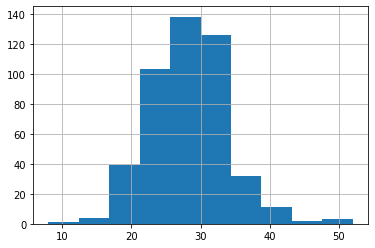

In [576]:
actual_v_predicted.PredictedScores.hist()

In [577]:
actual_v_predicted

Titles  RottenScores  \
408                              running_with_the_devil            24   
702                                   love_beats_rhymes            44   
1253                                         abominable            80   
799                              the_battle_of_jangsari            49   
1475                                    the_hate_u_give            96   
78                                              hangman             4   
795                                            freetown            49   
653                                         the_prodigy            41   
746                                               clown            46   
75                                            get_a_job             4   
826                                           12_strong            51   
862                                           book_club            53   
1025                               annabelle_comes_home            64   
556                                   american_assassin            34   
1215                                 the_devils_doorway            77   
412                                   the_perfect_match            25   
692                                       captive_state            43   
211                                            spin_out            12   
1451                                  see_you_yesterday            94   
278                                               after            16   
1394                                        the_unicorn            90   
743                                    x_men_apocalypse            46   
1053                                         golden_boy            66   
215                                    woody_woodpecker            12   
474                                     the_whole_truth            29   
1519                                              artik            99   
462                                     passage_to_mars            28   
137                                         all_nighter             7   
1273                                         boy_erased            81   
1206                            anna_and_the_apocalypse            76   
1072                                       sister_aimee            67   
489                                                  io            30   
23                                          dark_crimes             0   
1512                                               kedi            98   
459                                             bethany            28   
682                                 holiday_in_the_wild            42   
555                                        24_exposures            34   
465                                             paradox            28   
969                                     war_on_everyone            61   
1056                nancy_drew_and_the_hidden_staircase            66   
1267                                         fast_color            81   
573                                            snatched            35   
1084                                        final_score            68   
784                                            good_sam            49   
1109                                           the_king            70   
1383                                           starfish            89   
250                                        little_italy            15   
154                                      fantastic_four             8   
869                                        gemma_bovery            53   
687                               christmas_inheritance            43   
93                                          dream_house             5   
820                          kingsman_the_golden_circle            51   
279                                              swiped            16   
1288                                        coyote_lake            82   
669                               

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



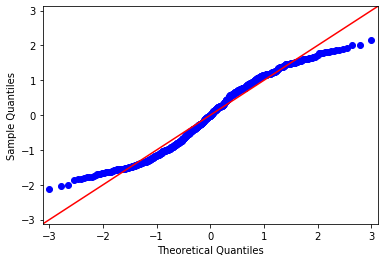

In [578]:
residuals = model_1.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

### TFIDF with Statsmodels OLS

In [579]:
# re_indexed = rotten_df_cut.set_index('Titles')

In [580]:
X_train, X_test, y_train, y_test = train_test_split(rotten_df_cut.NoStop,
                                                    rotten_df_cut.RottenScores, test_size=.3,
                                                    random_state=42)

In [581]:
tfidf = TfidfVectorizer(max_features=1500, max_df=.95, min_df=.1, 
                        ngram_range=(1,2))
word_predictors = tfidf.fit_transform(X_train)
word_test = tfidf.transform(X_test)

In [582]:
predictors_spf = pd.SparseDataFrame(word_predictors, 
                                   columns=tfidf.get_feature_names())

In [583]:
word_test_spf = pd.SparseDataFrame(word_test,
                                   columns=tfidf.get_feature_names())

In [584]:
predictors_df = pd.DataFrame(predictors_spf,
                             columns=tfidf.get_feature_names())

In [585]:
word_test_df = pd.DataFrame(word_test_spf, columns=tfidf.get_feature_names())

In [586]:
to_drop = ['and','not','else','try','with','for','break','finally','while',
           'assert','continue','except','pass','raise','yield','raise',
           'return','from','or','if','in','is','class']
drop = []
for column in predictors_df.columns:
    if column in to_drop:
        drop.append(column)
    try:
        if int(column) > -1:
            drop.append(column)
    except:
        pass

In [587]:
predictors_df.drop(drop, axis=1, inplace=True)
word_test_df.drop(drop, axis=1, inplace=True)

In [588]:
predictors_df.fillna(0, inplace=True)
word_test_df.fillna(0, inplace=True)

In [589]:
for column in tqdm(predictors_df.columns):
    if column.find(' ') > -1:
        rep = column.replace(' ', '_')
        predictors_df.rename(columns={column: rep}, inplace=True)
        word_test_df.rename(columns={column: rep}, inplace=True)

100%|██████████| 1466/1466 [01:41<00:00, 14.39it/s]


In [590]:
target = rotten_df_cut.RottenScores
formula = "RottenScores~" + "+".join(predictors_df.columns)

In [591]:
data = predictors_df.merge(y_train, left_index=True, right_index=True)

model_2 = ols(formula=formula, data=data).fit()

In [592]:
model_2.rsquared

0.998199640844065

In [593]:
y_pred = model_2.predict(word_test_df)

In [594]:
actual_v_predicted = X_test.to_frame()

In [595]:
pred_scores = list(y_pred)

In [596]:
actual_v_predicted['PredictedScores'] = pred_scores

In [597]:
to_merge = rotten_df_cut[['Titles', 'RottenScores']]

In [598]:
actual_v_predicted = actual_v_predicted.merge(to_merge, left_index=True,
                                              right_index=True)

In [599]:
actual_v_predicted = actual_v_predicted[['Titles','RottenScores',
                                         'PredictedScores']]

In [600]:
actual_v_predicted['PredictedScores'] = actual_v_predicted.PredictedScores.\
    apply(lambda x: int(x))

In [601]:
actual_v_predicted

Titles  RottenScores  \
1346                                          pavarotti            86   
76                      big_mommas_like_father_like_son             4   
1010                                           dead_ant            63   
660                                         the_package            41   
1133                                          snapshots            71   
982                                                edie            61   
1456                                    becoming_astrid            95   
1497                                            mcqueen            98   
1498                                       the_big_sick            98   
1190                                    swinging_safari            76   
1512                                               kedi            98   
628                                      justice_league            39   
394                                            rememory            24   
1479                                             border            96   
514                                         the_chamber            32   
626                                           nostalgia            39   
1114                                         horse_girl            70   
30                           mortal_kombat_annihilation             1   
49                                    battlefield_earth             2   
240                                            man_down            14   
429                                    rambo_last_blood            26   
351                                         i_hate_kids            21   
124                                            reprisal             7   
551                                   welcome_to_marwen            34   
1492                                             maiden            97   
70                                        vampires_suck             3   
1110                                    triple_frontier            70   
1032                                              siren            65   
1089                                           oceans_8            68   
1489                                               coco            97   
566                                         blair_witch            35   
342                                   the_book_of_henry            21   
1521                      invader_zim_enter_the_florpus            99   
932                                        charlie_says            58   
817                                       the_interview            51   
661                                          the_valley            41   
1080                                        the_journey            68   
1344                                           depraved            86   
493                                        loving_pablo            30   
481                                            red_joan            29   
1406                                    maria_by_callas            91   
943                                    operation_finale            59   
1310                                      the_vanishing            84   
571                                    state_like_sleep            35   
352                                                 222            21   
261                                         the_fanatic            15   
59                                              6_souls             3   
1392                                        gloria_bell            90   
1068                              zombieland_double_tap            67   
1276                     pope_francis_a_man_of_his_word            81   
259                                           show_dogs            15   
371                                    rim_of_the_world            22   
297                                               chips            18   
324                                  beneath_the_leaves            19   
306                      the_posse

In [602]:
type(word_predictors)

scipy.sparse.csr.csr_matrix

In [603]:
y_hat_train = model_2.predict(predictors_df)
y_hat_test = model_2.predict(word_test_df)

In [604]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [605]:
train_residuals = y_hat_train - list(y_train)
test_residuals = y_hat_test - list(y_test)

In [606]:
high_scores = [score for score in test_residuals if abs(score) >=50]
low_scores = [score for score in test_residuals if abs(score) <50]

In [607]:
print(len(high_scores))
print(len(low_scores))

143
316


In [608]:
(len(low_scores) - len(high_scores)) / len(low_scores)

0.5474683544303798

In [609]:
sum(abs(test_residuals)) / len(test_residuals)

39.36998055134432

In [610]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 0.4943820224719101
Test Mean Squarred Error: 380.90713412610654


In [611]:
print('R-sq score:', r2_score(y_test,y_hat_test))

R-sq score: -1.686241663543493


In [612]:
y_pred = model_1.predict(scaled_X_test)

In [613]:
actual_v_predicted = X_test.copy()

In [614]:
type(pred_scores)

list

In [615]:
pred_scores = pd.Series(pred_scores, name='PredictedScores')

In [616]:
X_test.head()

1346     brazil. night before, luciano sang 200,000 pe...
76       (singing) yeah it's classic, baby i've world,...
1010     1 people peyote generations open mind explore...
660      okay, now... it's time bowling. right. come o...
1133     answers phone! drives nuts. you're driving nu...
Name: NoStop, dtype: object

In [617]:
actual_v_predicted = pd.concat([y_test, pred_scores], axis=1, )

In [618]:
actual_v_predicted = to_merge.merge(actual_v_predicted, left_index=True,
                                              right_index=True)

In [619]:
list(zip(list(y_test), list(pred_scores)))

[(86, 42.87228071977921),
 (4, 66.08587280657763),
 (63, 55.29472810187464),
 (41, 17.85220722272875),
 (71, 34.547520551247516),
 (61, -12.327223263729381),
 (95, 21.084784970947204),
 (98, -27.36843524778471),
 (98, 41.855041453564304),
 (76, 24.995117759495788),
 (98, 59.3990988139366),
 (39, 19.11778526960859),
 (24, 62.342804026332516),
 (96, 77.22232315112372),
 (32, 41.209812392086405),
 (39, 1.2386881291733394),
 (70, 14.755538876212686),
 (1, 69.81943037536831),
 (2, 52.71190606672175),
 (14, 45.01595117856518),
 (26, 33.45356523315033),
 (21, 57.80549306412095),
 (7, 17.341440529913214),
 (34, 49.86970300616837),
 (97, 57.387575010360806),
 (3, 22.191261550305587),
 (70, -19.07078776625112),
 (65, 42.3231027736378),
 (68, 148.86420505054093),
 (97, 17.058149508434205),
 (35, 60.60441623925168),
 (21, 56.71831169459834),
 (99, 22.555237168921625),
 (58, 15.300612201371221),
 (51, -19.512386730741284),
 (41, 57.15655201795403),
 (68, 53.441142098463615),
 (86, 48.40997293928404

### TFIDF with sklearn

In [620]:
X_train, X_test, y_train, y_test = train_test_split(rotten_df_cut.NoStop,
                                                    target, test_size=.3,
                                                    random_state=42)

In [621]:
tfidf = TfidfVectorizer(max_features=1000, max_df=.95, min_df=.1, 
                        ngram_range=(1,2))
word_predictors = tfidf.fit_transform(X_train)
word_test = tfidf.transform(X_test)

In [622]:
predictors_spf = pd.SparseDataFrame(word_predictors, 
                                   columns=tfidf.get_feature_names(),
                                   default_fill_value=0)

In [623]:
word_test_spf = pd.SparseDataFrame(word_test, 
                                   columns=tfidf.get_feature_names(),
                                   default_fill_value=0)

In [624]:
X = predictors_spf
vif = [variance_inflation_factor(X.values, i) for i in tqdm(range(X.shape[1]))]
vif_list = sorted(list(zip(predictors_spf.columns, vif)), key=lambda x: x[1],
                  reverse=True)

100%|██████████| 1000/1000 [13:18<00:00,  1.20it/s]


In [625]:
revised_list = [item[0] for item in vif_list if item[1] < 20]

In [626]:
print('original: ', len(predictors_spf.columns))
print('remaining: ', len(revised_list))

original:  1000
remaining:  53


In [627]:
predictors_spf = predictors_spf[revised_list]
word_test_spf = word_test_spf[revised_list]

In [628]:
lr = LinearRegression()
model = lr.fit(predictors_spf, y_train)

In [629]:
model.score(predictors_spf, y_train)

0.08725750913691699

In [630]:
model.score(word_test_spf, y_test)

-0.055917588028620686

In [631]:
y_hat_train = model.predict(predictors_spf)
y_hat_test = model.predict(word_test_spf)

In [632]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [633]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 754.845500332331
Test Mean Squarred Error: 885.3356431004476


In [634]:
actual_v_predicted = X_test.to_frame()

In [636]:
pred_scores = list(y_hat_test)

In [637]:
actual_v_predicted['PredictedScores'] = pred_scores

In [638]:
to_merge = rotten_df_cut[['Titles', 'RottenScores']]

In [639]:
actual_v_predicted = actual_v_predicted.merge(to_merge, left_index=True,
                                              right_index=True)

In [640]:
actual_v_predicted = actual_v_predicted[['Titles','RottenScores',
                                         'PredictedScores']]

In [641]:
actual_v_predicted['PredictedScores'] = actual_v_predicted.PredictedScores.\
    progress_apply(lambda x: int(x))

In [642]:
actual_v_predicted.PredictedScores.value_counts()

46    35
48    30
44    30
47    29
49    29
43    28
45    28
52    25
42    22
50    22
41    20
54    16
51    16
53    13
37    11
38    11
40    10
33     9
39     8
34     7
36     7
55     6
57     5
58     4
35     4
56     4
59     3
22     2
65     2
26     2
64     2
63     2
62     2
71     2
61     2
60     2
32     2
19     1
31     1
98     1
67     1
68     1
70     1
10     1
Name: PredictedScores, dtype: int64

In [643]:
actual_v_predicted.head(30)

Titles  RottenScores  PredictedScores
1346                        pavarotti            86               48
76    big_mommas_like_father_like_son             4               52
1010                         dead_ant            63               52
660                       the_package            41               58
1133                        snapshots            71               45
982                              edie            61               41
1456                  becoming_astrid            95               50
1497                          mcqueen            98               65
1498                     the_big_sick            98               47
1190                  swinging_safari            76               56
1512                             kedi            98               42
628                    justice_league            39               40
394                          rememory            24               50
1479                           border            96               47
514                       the_chamber            32               47
626                         nostalgia            39               49
1114                       horse_girl            70               47
30         mortal_kombat_annihilation             1               47
49                  battlefield_earth             2               40
240                          man_down            14               43
429                  rambo_last_blood            26               46
351                       i_hate_kids            21               50
124                          reprisal             7               43
551                 welcome_to_marwen            34               34
1492                           maiden            97               41
70                      vampires_suck             3               51
1110                  triple_frontier            70               43
1032                            siren            65               47
1089                         oceans_8            68               41
1489                             coco            97               60

### TFIDF with Decision Tree Classifier

In [644]:
# test = grid_search_c(rotten_df_cut.NoStop, target, DecisionTreeRegressor(), params)

In [645]:
X_train, X_test, y_train, y_test = train_test_split(rotten_df_cut.NoStop,
                                                    target, test_size=.3,
                                                    random_state=42)

In [646]:
tfidf = TfidfVectorizer(max_features=5000, max_df=.95, min_df=.1, 
                        ngram_range=(1,2))
word_predictors = tfidf.fit_transform(X_train)
word_test = tfidf.transform(X_test)

In [647]:
predictors_spf = pd.SparseDataFrame(word_predictors, 
                                   columns=tfidf.get_feature_names(),
                                   default_fill_value=0)

In [648]:
word_test_spf = pd.SparseDataFrame(word_test, 
                                   columns=tfidf.get_feature_names(),
                                   default_fill_value=0)

In [649]:
params = {'max_depth': [0,1,2,5,10,15,20],
          'min_samples_split': [1,2,5,10],
          'min_samples_leaf': [1,2,5,10]
         }
          

In [650]:
# search = GridSearchCV(DecisionTreeRegressor(), cv=3,
#                            return_train_score=True, verbose=10,
#                            scoring='r2', param_grid=params,
#                            n_jobs=-1)

# # Performs a grid search and generates the best parameter set.
# search.fit(predictors_spf, y_train)

In [652]:
# search.best_params_

In [653]:
model = DecisionTreeRegressor(random_state=42, max_depth=2, min_samples_leaf=50,
                              min_samples_split=50)
model.fit(predictors_spf, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=50, min_samples_split=50,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [654]:
y_pred = model.predict(word_test_spf)
print('MSE score:', mse(y_test, y_pred))
print('R-sq score:', r2_score(y_test,y_pred))

MSE score: 810.2829962645452
R-sq score: 0.033595819050075915


In [655]:
model.score(predictors_spf, y_train)

0.09468688157089733

In [656]:
model.score(word_test_spf, y_test)

0.033595819050075915

In [657]:
y_hat_train = model.predict(predictors_spf)
y_hat_test = model.predict(word_test_spf)

In [658]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [659]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 748.7013486047389
Test Mean Squarred Error: 810.2829962645452


In [660]:
actual_v_predicted = X_test.to_frame()

In [661]:
pred_scores = list(y_pred)

In [662]:
actual_v_predicted['PredictedScores'] = pred_scores

In [663]:
to_merge = rotten_df_cut[['Titles', 'RottenScores']]

In [664]:
actual_v_predicted = actual_v_predicted.merge(to_merge, left_index=True,
                                              right_index=True)

In [665]:
actual_v_predicted = actual_v_predicted[['Titles','RottenScores',
                                         'PredictedScores']]

In [666]:
actual_v_predicted['PredictedScores'] = actual_v_predicted.PredictedScores.\
    apply(lambda x: int(x))

In [667]:
actual_v_predicted.PredictedScores.value_counts()

47    308
34     87
71     42
44     22
Name: PredictedScores, dtype: int64

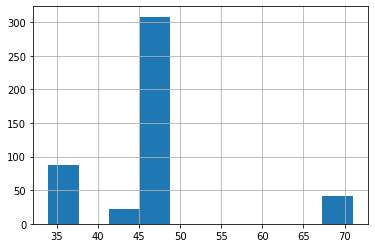

In [668]:
actual_v_predicted.PredictedScores.hist()

In [669]:
actual_v_predicted.head(30)

Titles  RottenScores  PredictedScores
1346                        pavarotti            86               44
76    big_mommas_like_father_like_son             4               47
1010                         dead_ant            63               47
660                       the_package            41               34
1133                        snapshots            71               47
982                              edie            61               47
1456                  becoming_astrid            95               34
1497                          mcqueen            98               71
1498                     the_big_sick            98               47
1190                  swinging_safari            76               47
1512                             kedi            98               71
628                    justice_league            39               47
394                          rememory            24               47
1479                           border            96               34
514                       the_chamber            32               47
626                         nostalgia            39               44
1114                       horse_girl            70               47
30         mortal_kombat_annihilation             1               34
49                  battlefield_earth             2               47
240                          man_down            14               47
429                  rambo_last_blood            26               71
351                       i_hate_kids            21               47
124                          reprisal             7               47
551                 welcome_to_marwen            34               34
1492                           maiden            97               71
70                      vampires_suck             3               34
1110                  triple_frontier            70               47
1032                            siren            65               47
1089                         oceans_8            68               47
1489                             coco            97               47

### TFIDF with XGBoost Regressor

I grid searched the hell out of this one, only to find that none of it mattered. So I removed the grid search function.

In [670]:
X_train, X_test, y_train, y_test = train_test_split(rotten_df_cut.NoStop,
                                                    target, test_size=.3,
                                                    random_state=42)

In [671]:
tfidf = TfidfVectorizer(max_features=5000, max_df=.9, min_df=.1, 
                        ngram_range=(1,2))
word_predictors = tfidf.fit_transform(X_train)
word_test = tfidf.transform(X_test)

In [672]:
model = XGBRegressor(random_state=42, n_estimators=100, 
                     objective='reg:squarederror')
model.fit(word_predictors, y_train)

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [673]:
y_pred = model.predict(word_test)
print('MSE score:', mse(y_test, y_pred))
print('R-sq score:', r2_score(y_test,y_pred))

MSE score: 743.6977868338219
R-sq score: 0.1130103261789761


In [674]:
model.score(word_predictors, y_train)

0.7954558705347395

In [675]:
model.score(word_test, y_test)

0.1130103261789761

In [676]:
y_hat_train = model.predict(word_predictors)
y_hat_test = model.predict(word_test)

In [677]:
type(y_train)

pandas.core.series.Series

In [678]:
train_residuals = y_hat_train - list(y_train)
test_residuals = y_hat_test - list(y_test)

In [679]:
high_scores = [score for score in test_residuals if abs(score) >=50]
low_scores = [score for score in test_residuals if abs(score) <50]

In [680]:
print(len(high_scores))
print(len(low_scores))

22
437


In [681]:
(len(low_scores) - len(high_scores)) / len(low_scores)

0.9496567505720824

In [684]:
sum(abs(test_residuals)) / len(test_residuals)

22.875444088106843

In [685]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 169.15966692889117
Test Mean Squarred Error: 743.6977868338219


In [686]:
actual_v_predicted = X_test.to_frame()

In [687]:
pred_scores = list(y_pred)

In [688]:
actual_v_predicted['PredictedScores'] = pred_scores

In [689]:
to_merge = rotten_df_cut[['Titles', 'RottenScores']]

In [690]:
actual_v_predicted = actual_v_predicted.merge(to_merge, left_index=True,
                                              right_index=True)

In [691]:
actual_v_predicted = actual_v_predicted[['Titles','RottenScores',
                                         'PredictedScores']]

In [692]:
actual_v_predicted['PredictedScores'] = actual_v_predicted.PredictedScores.\
    apply(lambda x: int(x))

In [1070]:
upside = len(actual_v_predicted[(actual_v_predicted.RottenScores > 50) \
                   & (actual_v_predicted.PredictedScores > 50)])
upside

97

In [1071]:
downside = len(actual_v_predicted[(actual_v_predicted.RottenScores < 50) \
                   & (actual_v_predicted.PredictedScores < 50)])
downside

166

In [1073]:
all_sides = len(actual_v_predicted)
all_sides

459

In [1068]:
(upside + downside) / len(actual_v_predicted)

0.5729847494553377

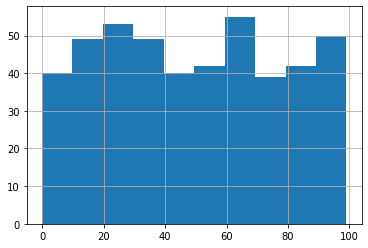

In [693]:
actual_v_predicted.RottenScores.hist();

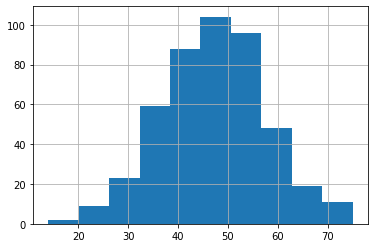

In [694]:
actual_v_predicted.PredictedScores.hist();

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



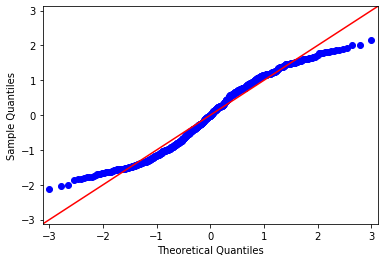

In [695]:
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show();

In [696]:
actual_v_predicted

Titles  RottenScores  \
1346                                          pavarotti            86   
76                      big_mommas_like_father_like_son             4   
1010                                           dead_ant            63   
660                                         the_package            41   
1133                                          snapshots            71   
982                                                edie            61   
1456                                    becoming_astrid            95   
1497                                            mcqueen            98   
1498                                       the_big_sick            98   
1190                                    swinging_safari            76   
1512                                               kedi            98   
628                                      justice_league            39   
394                                            rememory            24   
1479                                             border            96   
514                                         the_chamber            32   
626                                           nostalgia            39   
1114                                         horse_girl            70   
30                           mortal_kombat_annihilation             1   
49                                    battlefield_earth             2   
240                                            man_down            14   
429                                    rambo_last_blood            26   
351                                         i_hate_kids            21   
124                                            reprisal             7   
551                                   welcome_to_marwen            34   
1492                                             maiden            97   
70                                        vampires_suck             3   
1110                                    triple_frontier            70   
1032                                              siren            65   
1089                                           oceans_8            68   
1489                                               coco            97   
566                                         blair_witch            35   
342                                   the_book_of_henry            21   
1521                      invader_zim_enter_the_florpus            99   
932                                        charlie_says            58   
817                                       the_interview            51   
661                                          the_valley            41   
1080                                        the_journey            68   
1344                                           depraved            86   
493                                        loving_pablo            30   
481                                            red_joan            29   
1406                                    maria_by_callas            91   
943                                    operation_finale            59   
1310                                      the_vanishing            84   
571                                    state_like_sleep            35   
352                                                 222            21   
261                                         the_fanatic            15   
59                                              6_souls             3   
1392                                        gloria_bell            90   
1068                              zombieland_double_tap            67   
1276                     pope_francis_a_man_of_his_word            81   
259                                           show_dogs            15   
371                                    rim_of_the_world            22   
297                                               chips            18   
324                                  beneath_the_leaves            19   
306                      the_posse

### Features Only with XG Boost Regressor

In [536]:
rotten_df_cut.rename(columns={'.':'PER'}, inplace=True)

In [697]:
to_drop = rotten_df_cut.columns[:10]
to_drop = to_drop.append(rotten_df_cut.columns[21:26])

In [699]:
to_drop

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Titles', 'TitlesFormatted',
       'RottenScores', 'Scripts', 'AllTogetherNow', 'NoStop', 'JustWords',
       'sentiment_scores', 'category', 'CategoryLabel', 'nlp', 'POSCounts',
       'TAGCounts'],
      dtype='object')

In [700]:
to_drop_2 = ['sentiment_compound', 'unique_words', 'X', 'JJ', 'NNP', 'DET',
             'semi_ratios', 'ADJ', 'POSCounts', 'TAGCounts']

In [701]:
predictors_1 = rotten_df_cut[rotten_df_cut.columns[9:20]]
predictors_2 = rotten_df_cut[rotten_df_cut.columns[26:43]]
predictors_3 = rotten_df_cut[rotten_df_cut.columns[43:52]]
predictors_all = rotten_df_cut.copy()
predictors_all.drop(to_drop, axis=1, inplace=True)
predictors_all['category'] = rotten_df_cut.category
# predictors_all.drop(to_drop_2, axis=1,inplace=True)

In [702]:
predictors_all.columns

Index(['sentiment_negative', 'sentiment_neutral', 'sentiment_positive',
       'sentiment_compound', 'word_count', 'unique_words', 'colon_ratios',
       'semi_ratios', 'comma_ratios', 'ellipsis_ratios', 'SentenceLength',
       'PROPN', 'PUNCT', 'SYM', 'VERB', 'X', 'SPACE', 'ADJ', 'ADP', 'ADV',
       'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'NNP',
       'VBZ', 'DT', 'PER', 'CC', 'VBN', 'NN', 'JJ', '_SP', 'category'],
      dtype='object')

In [703]:
to_drop

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Titles', 'TitlesFormatted',
       'RottenScores', 'Scripts', 'AllTogetherNow', 'NoStop', 'JustWords',
       'sentiment_scores', 'category', 'CategoryLabel', 'nlp', 'POSCounts',
       'TAGCounts'],
      dtype='object')

In [704]:
X_train, X_test, y_train, y_test = train_test_split(predictors_all,
                                                    rotten_df_cut.RottenScores,
                                                    test_size=.3)

In [705]:
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)

In [706]:
temp = X_train_df.category
temp2 = X_test_df.category

In [707]:
X_train_df = X_train_df.drop(['category'], axis=1)
X_test_df = X_test_df.drop(['category'], axis=1)

In [709]:
scaler = StandardScaler()
scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train_df), 
                          columns = X_train_df.columns)
scaled_X_test = pd.DataFrame(scaler.transform(X_test_df), 
                            columns=X_test_df.columns)

In [710]:
scaled_y_train = scaler.fit_transform(np.array(y_train).reshape(-1,1))
scaled_y_test = scaler.transform(np.array(y_test).reshape(-1,1))
scaled_y_train = pd.Series(scaled_y_train.reshape(-1,), name='RottenScores')
scaled_y_test = pd.Series(scaled_y_test.reshape(-1,), name='RottenScores')

In [711]:
scaled_X_train['category'] = temp
scaled_X_test['category'] = temp2

In [712]:
scaled_X_train.fillna(0, inplace=True)
scaled_X_test.fillna(0, inplace=True)

In [713]:
def test(x):
    if x == 0:
        return math.log((X + 1) / 100)
    else:
        return math.log(x / 100)

In [714]:
# formula = 'RottenScores~' + '+'.join(scaled_X_train.columns)
# formula += '+C(category)'

In [715]:
# data = scaled_X_train.merge(y_train, left_index=True, right_index=True)
# model = ols(formula=formula, data=data).fit()

In [716]:
model = XGBRegressor(random_state=42, n_estimators=100, 
                     objective='reg:squarederror')
model.fit(scaled_X_train, y_train)

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [719]:
y_hat_train = model.predict(pd.DataFrame(scaled_X_train))
y_hat_test = model.predict(pd.DataFrame(scaled_X_test))

In [720]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [721]:
train_residuals = y_hat_train - list(y_train)
test_residuals = y_hat_test - list(y_test)

In [722]:
high_scores = [score for score in test_residuals if abs(score) >=50]
low_scores = [score for score in test_residuals if abs(score) <50]

In [723]:
print(len(high_scores))
print(len(low_scores))

21
438


In [724]:
(len(low_scores) - len(high_scores)) / len(low_scores)

0.952054794520548

In [725]:
sum(abs(test_residuals)) / len(test_residuals)

22.642985329389052

In [726]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 390.14625981140966
Test Mean Squarred Error: 731.6246255281433


In [769]:
print('R-sq score:', r2_score(y_test,y_hat_test))

R-sq score: 0.10003960722051763


In [770]:
y_pred = model_1.predict(scaled_X_test)

In [771]:
actual_v_predicted = X_test.copy()

In [772]:
pred_scores = list(y_pred)

In [773]:
actual_v_predicted['PredictedScores'] = pred_scores

In [774]:
to_merge = rotten_df_cut[['Titles', 'RottenScores']]

In [775]:
actual_v_predicted = actual_v_predicted.merge(to_merge, left_index=True,
                                              right_index=True)

In [776]:
actual_v_predicted = actual_v_predicted[['Titles','RottenScores',
                                         'PredictedScores']]

In [777]:
actual_v_predicted['PredictedScores'] = actual_v_predicted.PredictedScores.\
    apply(lambda x: int(x))

In [779]:
actual_v_predicted = actual_v_predicted[actual_v_predicted['PredictedScores'] <= 100]

In [780]:
actual_v_predicted.head()

Titles  RottenScores  PredictedScores
116     tomorrow_youre_gone             6               31
225         the_adventurers            13               20
598                  kidnap            37               16
399   madness_in_the_method            24               29
194  papa_hemingway_in_cuba            11               25

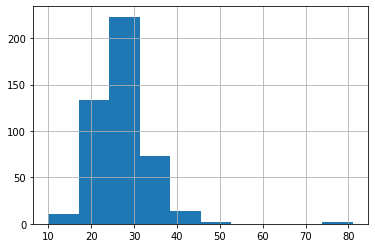

In [781]:
actual_v_predicted.PredictedScores.hist()

In [782]:
actual_v_predicted

Titles  RottenScores  \
116                             tomorrow_youre_gone             6   
225                                 the_adventurers            13   
598                                          kidnap            37   
399                           madness_in_the_method            24   
194                          papa_hemingway_in_cuba            11   
1188                                mega_time_squad            75   
699                            pacific_rim_uprising            43   
496                            a_bad_moms_christmas            30   
1310                                  the_vanishing            84   
201                                      first_kill            11   
314                                           polar            18   
1467                                   little_woods            95   
613                         the_mountain_between_us            38   
247                                    lets_be_evil            14   
594                                      donnybrook            37   
955                                     brian_banks            60   
724                           message_from_the_king            45   
184                                      ghost_team            10   
695                                   a_violent_man            43   
243                       sharknado_the_4th_awakens            14   
39                                alone_in_the_dark             1   
334                                      chopsticks            19   
1451                              see_you_yesterday            94   
1384                 john_wick_chapter_3_parabellum            89   
189                                      the_choice            10   
729                                     like_father            45   
655                                  the_laundromat            41   
40                                          twisted             1   
1053                                     golden_boy            66   
212                                    no_good_deed            12   
1238                        girl_on_the_third_floor            79   
1012                                    the_lullaby            63   
190               gods_not_dead_a_light_in_darkness            10   
1292                               official_secrets            82   
1216              scary_stories_to_tell_in_the_dark            77   
466                                    the_red_pill            28   
819                                    the_humbling            51   
1462                      bikram_yogi_guru_predator            95   
564                                  sugar_mountain            35   
1138                             a_christmas_prince            72   
1429                                    the_mustang            93   
200                                      peppermint            11   
634                                the_last_witness            39   
1184                          all_the_bright_places            75   
1108                            the_last_photograph            70   
1194                                     the_escape            76   
1347                                      the_golem            87   
1420                                  the_last_race            92   
521                                     dark_signal            32   
673                                   three_christs            42   
410                                       sleepless            24   
1305                                           girl            84   
912                                    420_massacre            56   
847                             destination_wedding            52   
147                                     cherry_tree             8   
474                                 the_whole_truth            29   
461                                          sunset            28   
1219                                     da

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



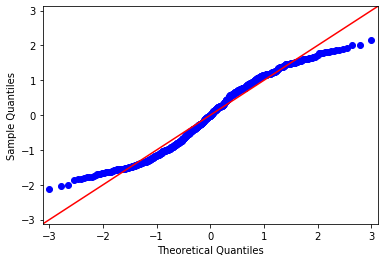

In [578]:
residuals = model_1.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

### TFIDF with Features with XG Boost Regressor

In [536]:
rotten_df_cut.rename(columns={'.':'PER'}, inplace=True)

In [697]:
to_drop = rotten_df_cut.columns[:10]
to_drop = to_drop.append(rotten_df_cut.columns[21:26])

In [699]:
to_drop

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Titles', 'TitlesFormatted',
       'RottenScores', 'Scripts', 'AllTogetherNow', 'NoStop', 'JustWords',
       'sentiment_scores', 'category', 'CategoryLabel', 'nlp', 'POSCounts',
       'TAGCounts'],
      dtype='object')

In [700]:
to_drop_2 = ['sentiment_compound', 'unique_words', 'X', 'JJ', 'NNP', 'DET',
             'semi_ratios', 'ADJ', 'POSCounts', 'TAGCounts']

In [938]:
predictors_1 = rotten_df_cut[rotten_df_cut.columns[9:20]]
predictors_2 = rotten_df_cut[rotten_df_cut.columns[26:43]]
predictors_3 = rotten_df_cut[rotten_df_cut.columns[43:52]]
predictors_all = rotten_df_cut.copy()
predictors_all.drop(to_drop, axis=1, inplace=True)
predictors_all['category'] = rotten_df_cut.category
# predictors_all.drop(to_drop_2, axis=1,inplace=True)

In [939]:
X = predictors_all

In [940]:
tfidf = TfidfVectorizer(max_features=5000, max_df=.9, min_df=.1, 
                        ngram_range=(1,2))
X2 = tfidf.fit_transform(rotten_df_cut.NoStop)

In [941]:
# Creating a sparse DataFrame to house both the features and the 
# processed text.
X_temp = pd.SparseDataFrame(X2, columns=tfidf.get_feature_names(),
                           default_fill_value=0)
# Necessary for next step.
X = X.reset_index(drop=True)

# Combining text matrix with script attributes.
for column in X:
    X_temp[column] = X[column]
X = X_temp

In [995]:
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X), y, random_state=42,
                                                    test_size=.3)

In [1018]:
len(X_train)

1068

In [996]:
# X_train_df = pd.DataFrame(X_train)
# X_test_df = pd.DataFrame(X_test)

In [997]:
# rus = RandomUnderSampler(random_state=42)
# X_train_df, y_train_df = rus.fit_resample(pd.DataFrame(X_train), y_train)

In [998]:
# temp = X_train_df.category
# temp2 = X_test_df.category

In [999]:
# X_train_df = X_train_df.drop(['category'], axis=1)
# X_test_df = X_test_df.drop(['category'], axis=1)

In [1022]:
scaler = StandardScaler()
scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train), 
                          columns = X_train.columns)
scaled_X_test = pd.DataFrame(scaler.transform(X_test), 
                            columns=X_test.columns)

In [1023]:
scaled_y_train = scaler.fit_transform(np.array(y_train).reshape(-1,1))
scaled_y_test = scaler.transform(np.array(y_test).reshape(-1,1))
scaled_y_train = pd.Series(scaled_y_train.reshape(-1,), name='RottenScores')
scaled_y_test = pd.Series(scaled_y_test.reshape(-1,), name='RottenScores')

In [1024]:
# scaled_X_train['category'] = temp
# scaled_X_test['category'] = temp2

In [1025]:
scaled_X_train.fillna(0, inplace=True)
scaled_X_test.fillna(0, inplace=True)

In [1026]:
def test(x):
    if x == 0:
        return math.log((X + 1) / 100)
    else:
        return math.log(x / 100)

In [1027]:
# scaled_X_train = pd.DataFrame(scaled_X_train)

In [1028]:
# scaled_X_train.category = scaled_X_train.category.astype(float)

In [1029]:
# types = [scaled_X_train[col].dtype for col in scaled_X_train.columns]


In [1030]:
# scaled_X_train.category.sparse.

In [1031]:
# formula = 'RottenScores~' + '+'.join(scaled_X_train.columns)
# formula += '+C(category)'

In [1032]:
# data = scaled_X_train.merge(y_train, left_index=True, right_index=True)
# model = ols(formula=formula, data=data).fit()

In [1033]:
# X_train_df = X_train_df.to_dense()

In [1034]:
X_train_df.able.dtype

Sparse[float64, 0]

In [1035]:
len(scaled_X_train)

1068

In [1036]:
model = XGBRegressor(random_state=42, n_estimators=100, 
                     objective='reg:squarederror')
model.fit(scaled_X_train, y_train)

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [1037]:
y_hat_train = model.predict(pd.DataFrame(scaled_X_train))
y_hat_test = model.predict(pd.DataFrame(scaled_X_test))

In [1038]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [1039]:
train_residuals = y_hat_train - list(y_train)
test_residuals = y_hat_test - list(y_test)

In [1040]:
high_scores = [score for score in test_residuals if abs(score) >=50]
low_scores = [score for score in test_residuals if abs(score) <50]

In [1041]:
print(len(high_scores))
print(len(low_scores))

18
441


In [1042]:
(len(low_scores) - len(high_scores)) / len(low_scores)

0.9591836734693877

In [1043]:
sum(abs(test_residuals)) / len(test_residuals)

23.303704808220626

In [1044]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 178.1017191250739
Test Mean Squarred Error: 748.9601753536298


In [1045]:
print('R-sq score:', r2_score(y_test,y_hat_test))

R-sq score: 0.10673400754614015


In [1047]:
y_pred = model.predict(scaled_X_test)

In [1048]:
actual_v_predicted = scaled_X_test.copy()

In [1049]:
pred_scores = list(y_pred)

In [1050]:
actual_v_predicted['PredictedScores'] = pred_scores

In [1051]:
to_merge = rotten_df_cut[['Titles', 'RottenScores']]

In [1052]:
actual_v_predicted = actual_v_predicted.merge(to_merge, left_index=True,
                                              right_index=True)

In [1053]:
actual_v_predicted = actual_v_predicted[['Titles','RottenScores',
                                         'PredictedScores']]

In [1054]:
actual_v_predicted['PredictedScores'] = actual_v_predicted.PredictedScores.\
    apply(lambda x: int(x))

In [1055]:
actual_v_predicted = actual_v_predicted[actual_v_predicted['PredictedScores'] <= 100]

In [1056]:
actual_v_predicted.head()

Titles  RottenScores  PredictedScores
1346                        pavarotti            86               76
76    big_mommas_like_father_like_son             4               33
1010                         dead_ant            63               40
660                       the_package            41               21
1133                        snapshots            71               43

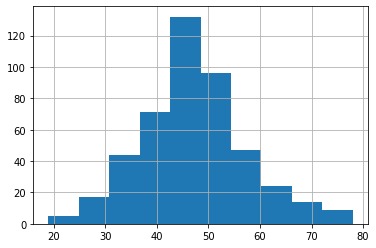

In [1057]:
actual_v_predicted.PredictedScores.hist()

In [1058]:
actual_v_predicted

Titles  RottenScores  \
1346                                          pavarotti            86   
76                      big_mommas_like_father_like_son             4   
1010                                           dead_ant            63   
660                                         the_package            41   
1133                                          snapshots            71   
982                                                edie            61   
1456                                    becoming_astrid            95   
1497                                            mcqueen            98   
1498                                       the_big_sick            98   
1190                                    swinging_safari            76   
1512                                               kedi            98   
628                                      justice_league            39   
394                                            rememory            24   
1479                                             border            96   
514                                         the_chamber            32   
626                                           nostalgia            39   
1114                                         horse_girl            70   
30                           mortal_kombat_annihilation             1   
49                                    battlefield_earth             2   
240                                            man_down            14   
429                                    rambo_last_blood            26   
351                                         i_hate_kids            21   
124                                            reprisal             7   
551                                   welcome_to_marwen            34   
1492                                             maiden            97   
70                                        vampires_suck             3   
1110                                    triple_frontier            70   
1032                                              siren            65   
1089                                           oceans_8            68   
1489                                               coco            97   
566                                         blair_witch            35   
342                                   the_book_of_henry            21   
1521                      invader_zim_enter_the_florpus            99   
932                                        charlie_says            58   
817                                       the_interview            51   
661                                          the_valley            41   
1080                                        the_journey            68   
1344                                           depraved            86   
493                                        loving_pablo            30   
481                                            red_joan            29   
1406                                    maria_by_callas            91   
943                                    operation_finale            59   
1310                                      the_vanishing            84   
571                                    state_like_sleep            35   
352                                                 222            21   
261                                         the_fanatic            15   
59                                              6_souls             3   
1392                                        gloria_bell            90   
1068                              zombieland_double_tap            67   
1276                     pope_francis_a_man_of_his_word            81   
259                                           show_dogs            15   
371                                    rim_of_the_world            22   
297                                               chips            18   
324                                  beneath_the_leaves            19   
306                      the_posse

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



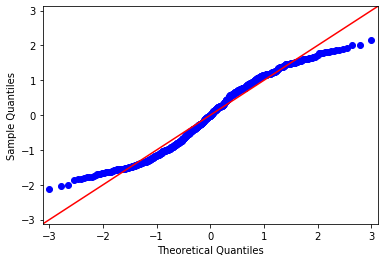

In [1059]:
residuals = model_1.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

## Fixing the Terrible Mistakes of My Past

### Support Vector Classifier

              precision    recall  f1-score   support

           0       0.81      0.76      0.79       455
           1       0.73      0.78      0.76       374

    accuracy                           0.77       829
   macro avg       0.77      0.77      0.77       829
weighted avg       0.77      0.77      0.77       829



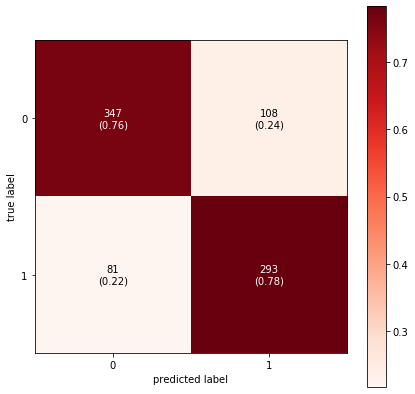

roc_auc score:  0.8386730916142681


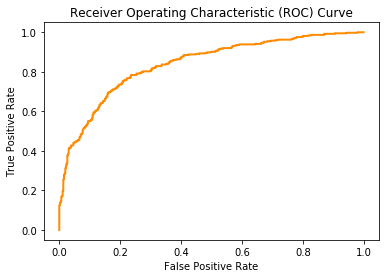

In [354]:
script_classifiers(X, y, SVC())

# Conclusions